In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

In [2]:
paths ={
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.T.raw.ADTfixedADT_70.20221022RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.T.raw.ADTfixedADT_70.20221022RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.T.raw.ADTfixedADT_70.20221022metadata.tsv',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.T.raw.ADTfixedADT_70.20221022RNA_and_ADT.TP10K.h5ad',
 'WNN_UMAP': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.T.raw.ADTfixedADT_70.20221022RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'}

# Run cNMF

In [4]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.20230907'

In [4]:
! ls ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/cnmf_tmp

HIVVaccine.20230907.gene_spectra_score.k_31.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_31.dt_0_18.df.npz
HIVVaccine.20230907.gene_spectra_score.k_32.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_32.dt_0_2.df.npz
HIVVaccine.20230907.gene_spectra_score.k_33.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_33.dt_0_18.df.npz
HIVVaccine.20230907.gene_spectra_score.k_34.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_34.dt_0_2.df.npz
HIVVaccine.20230907.gene_spectra_score.k_38.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_38.dt_0_2.df.npz
HIVVaccine.20230907.gene_spectra_score.k_39.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_39.dt_0_2.df.npz
HIVVaccine.20230907.gene_spectra_score.k_40.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_40.dt_0_2.df.npz
HIVVaccine.20230907.gene_spectra_score.k_46.dt_0_15.df.npz
HIVVaccine.20230907.gene_spectra_score.k_46.dt_0_2.df.npz
HIVVaccine.20230907.gene_spectra_tpm.k_31.dt_0_15.df.npz
HIVVa

In [5]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(15, 55)
n_iter = 20
num_per_node = 10

In [5]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [9]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [14]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

80

In [25]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.20230907 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.20230907 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 80 --worker-index 0"
Job <805440> is submitted to queue <short>.
bsub -q short -J HIVVaccine.20230907 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NU

In [26]:
! bjobs | wc -l

No unfinished job found
0


In [30]:
total_workers = int((len(Ks)*n_iter))
total_workers

800

In [58]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [59]:
len(missing)

0

In [60]:
! bjobs | wc -l

No unfinished job found
0


In [34]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.20230907 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.483.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.483.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.20230907 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 800 --worker-index 483"
Job <806293> is submitted to queue <short>.
bsub -q short -J HIVVaccine.20230907 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.487.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/log/HIVVaccine.20230907.487.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "ex

In [61]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 1h 9min 47s, sys: 54min 45s, total: 2h 4min 33s
Wall time: 5min 31s


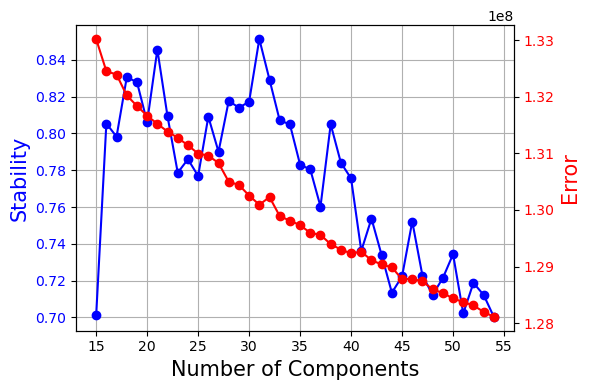

In [62]:
%%time
cnmf_obj.k_selection_plot()

In [6]:
figdir = '../../../Figures/Components'

In [8]:
cmd = 'cp {} {}'.format(cnmf_obj.paths['k_selection_plot'], 
                           os.path.join(figdir, '%s.k_selection.png' % name))

print(cmd)

cp -i ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/HIVVaccine.20230907.k_selection.png ../../../Figures/Components/HIVVaccine.20230907.k_selection.png


In [9]:
print(cmd)
! {cmd}

cp -i ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907/HIVVaccine.20230907.k_selection.png ../../../Figures/Components/HIVVaccine.20230907.k_selection.png


In [7]:
kthresh = {31:0.18, 32:0.2, 33:.18, 34:.2, 38:.2, 39:.2, 40:.2, 46:.2}


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


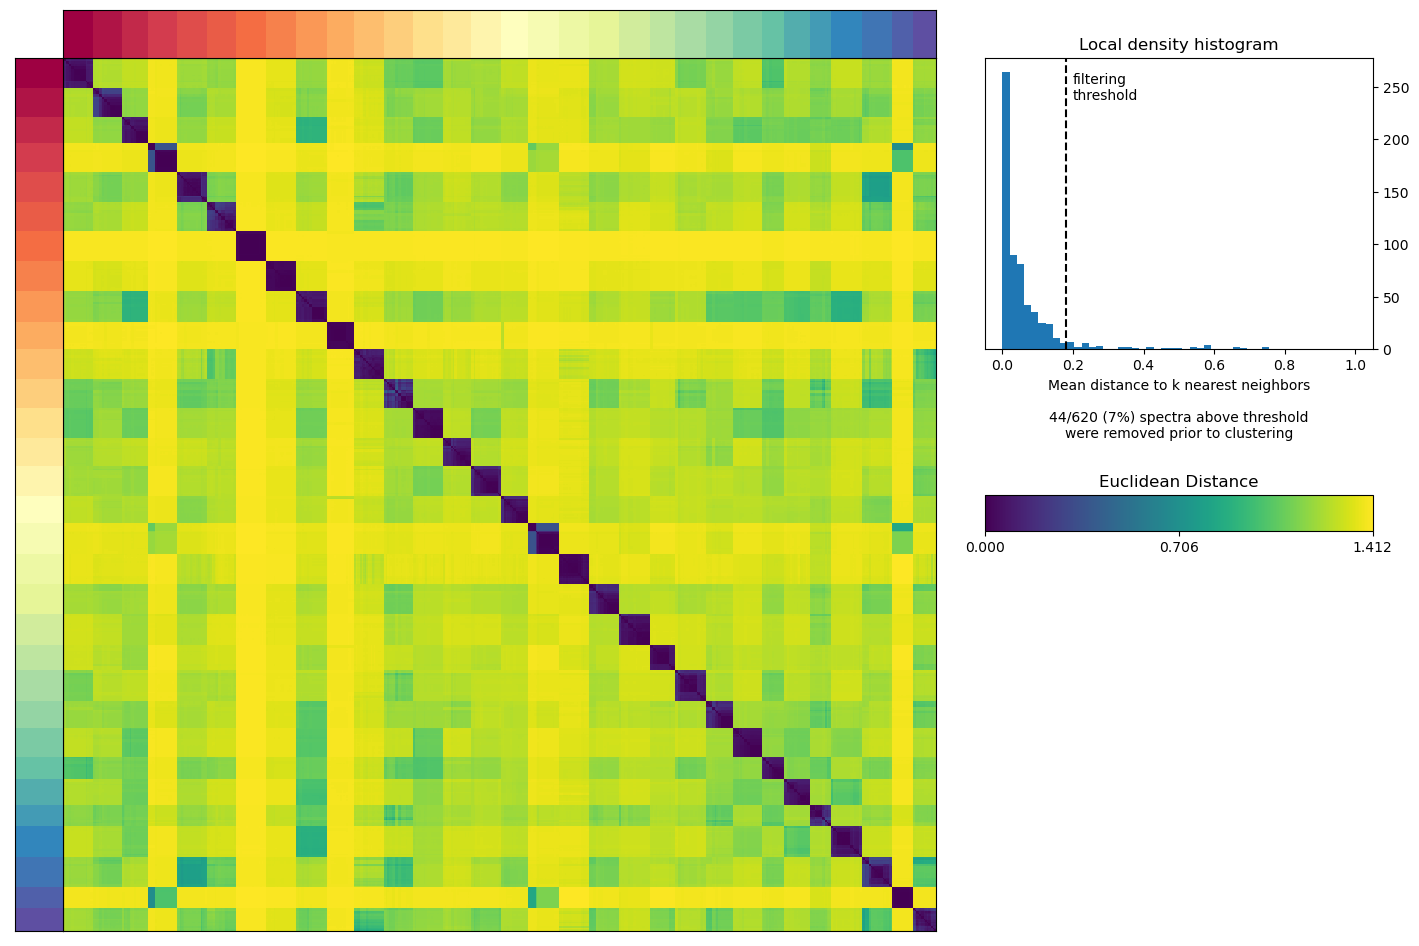

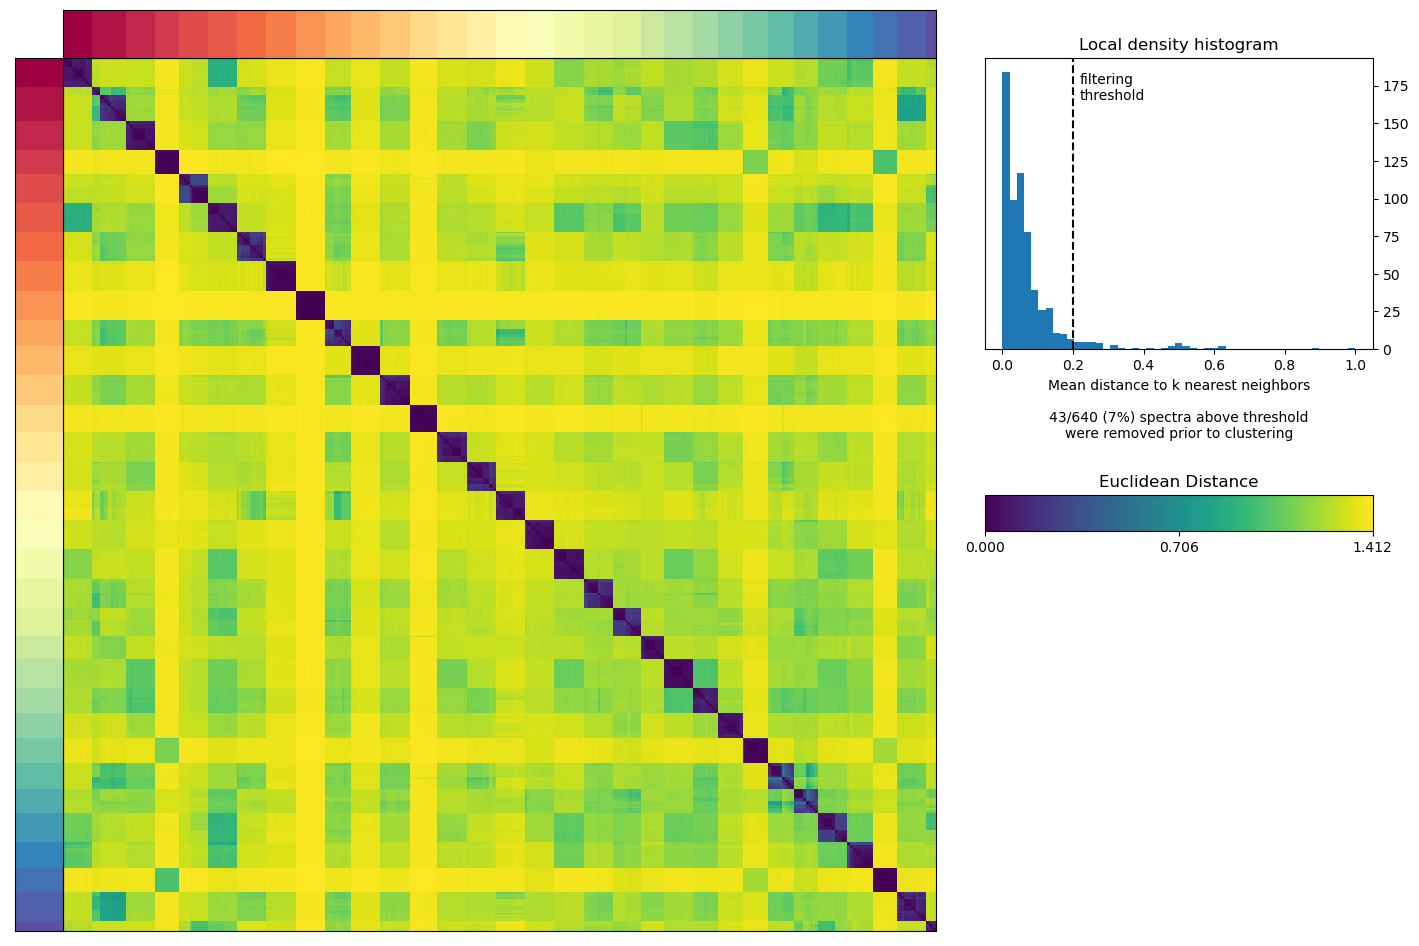

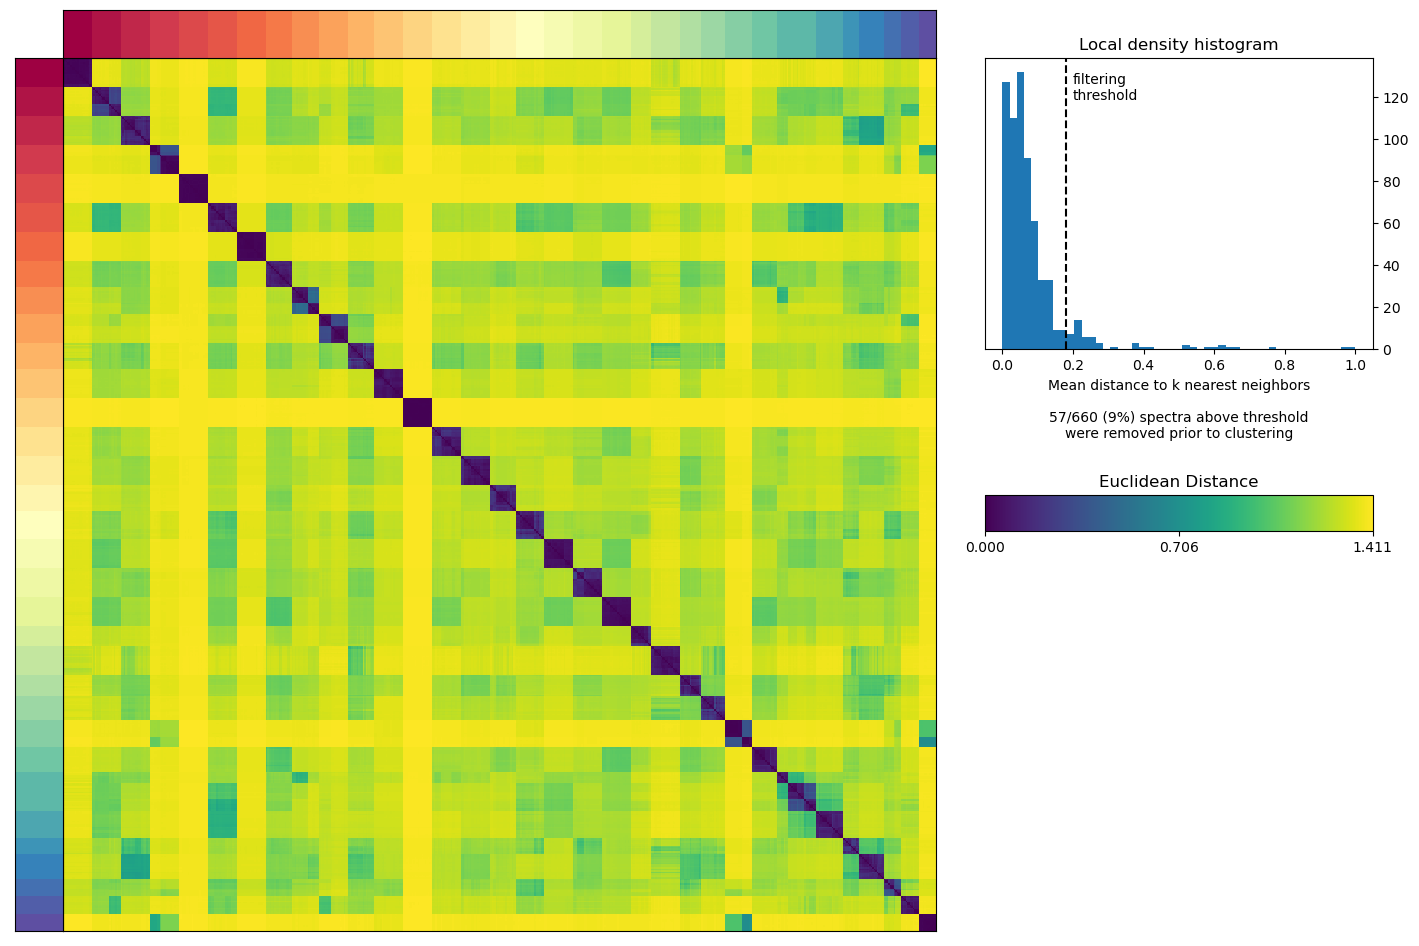

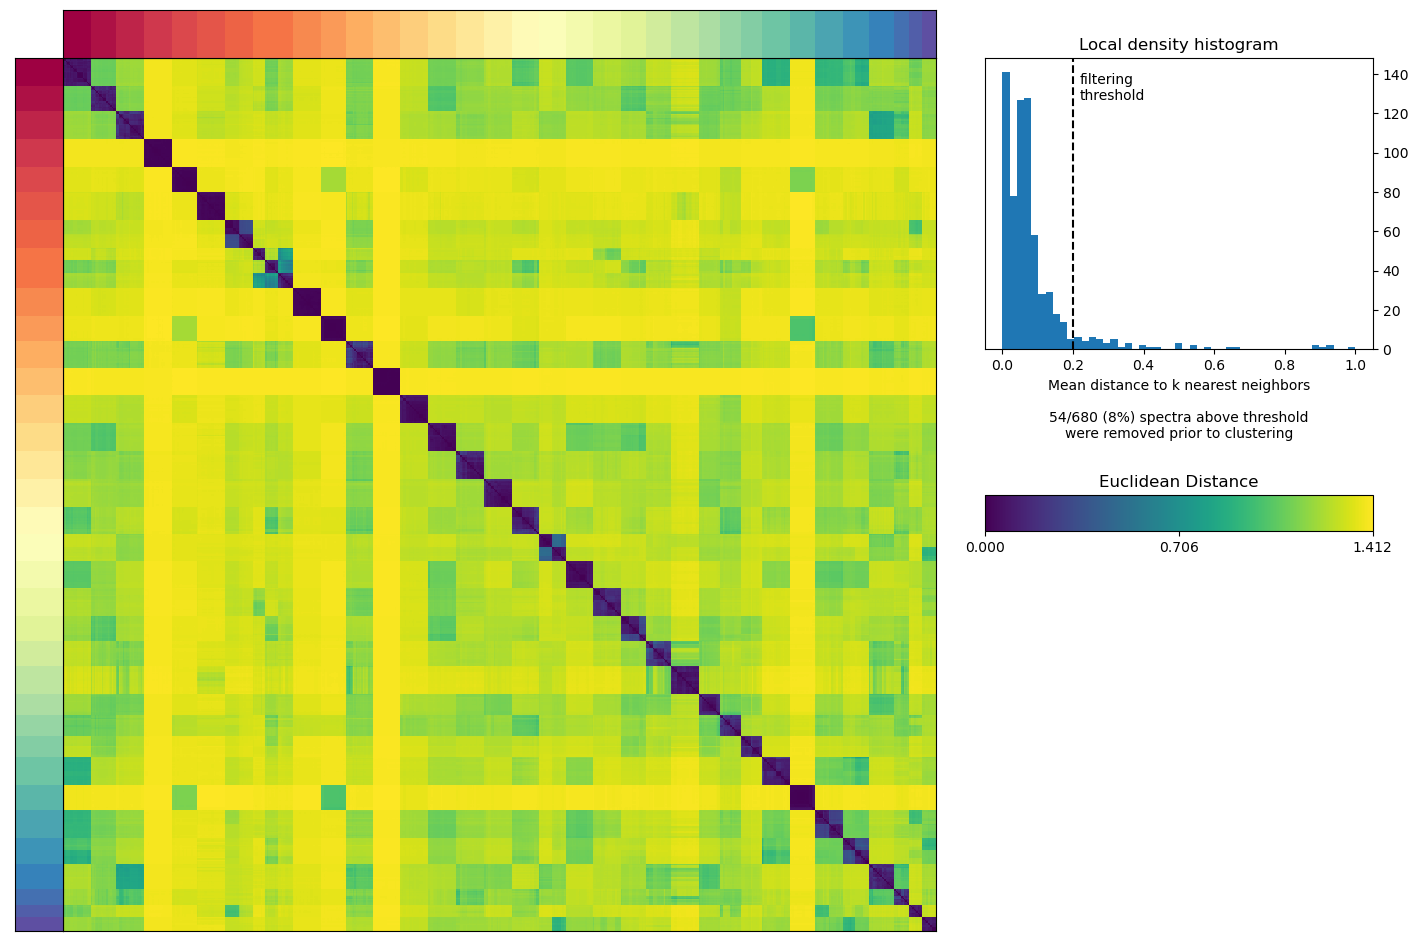

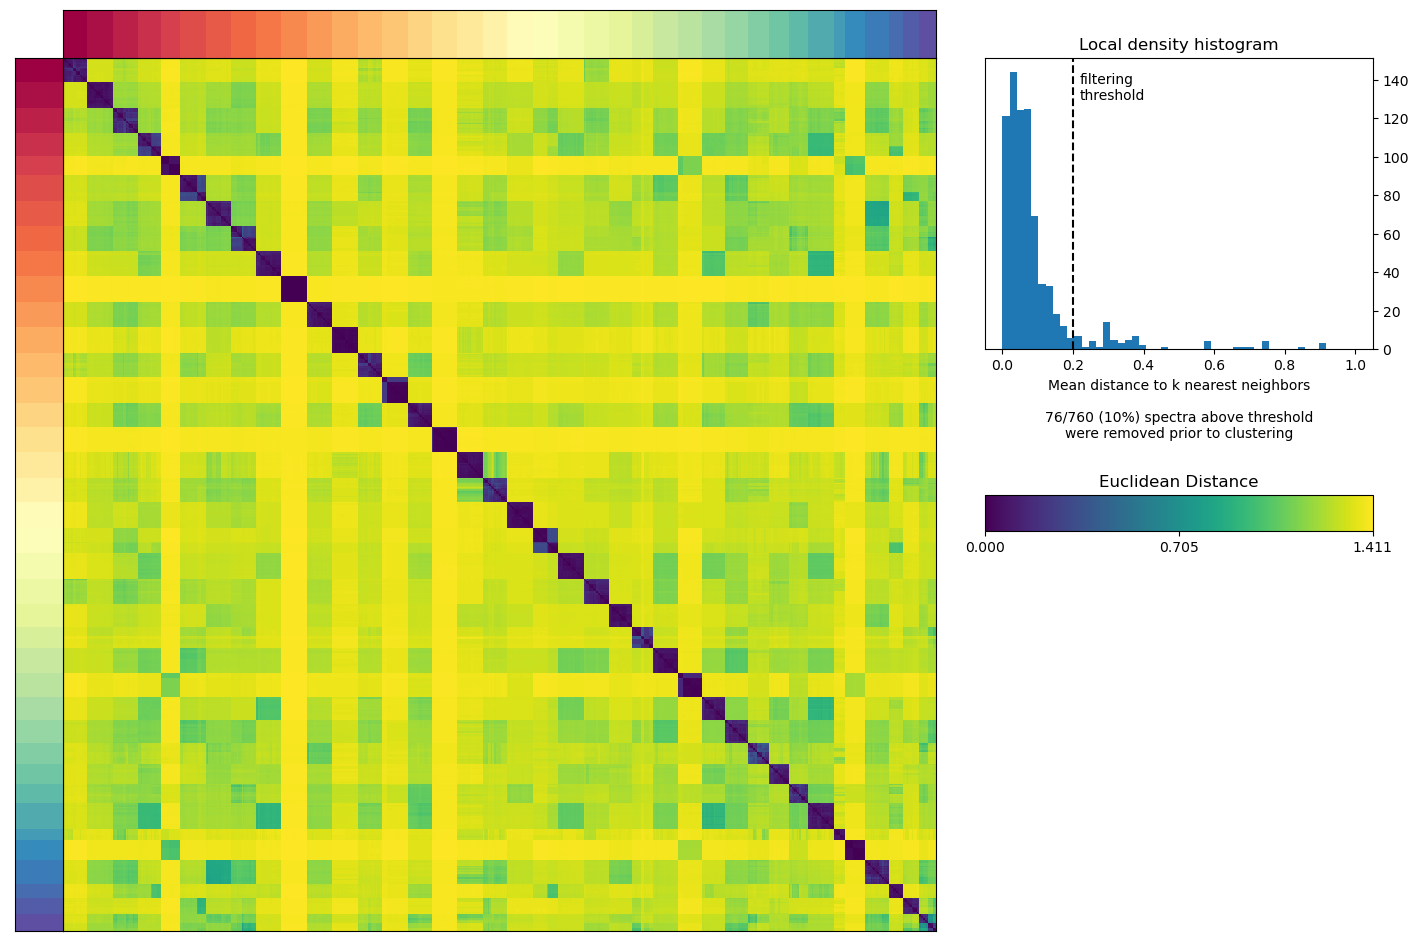

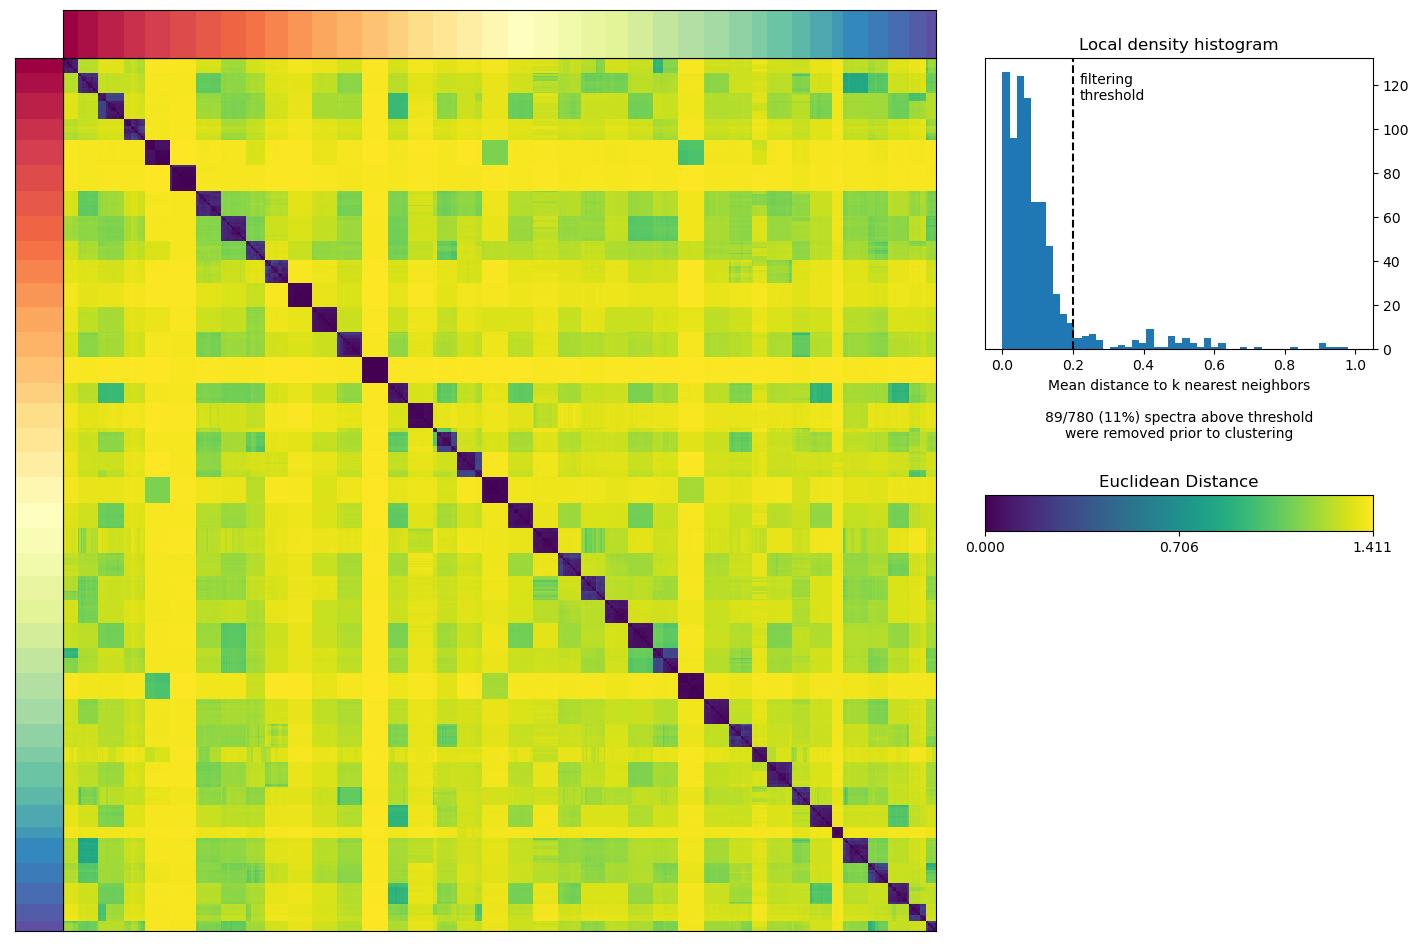

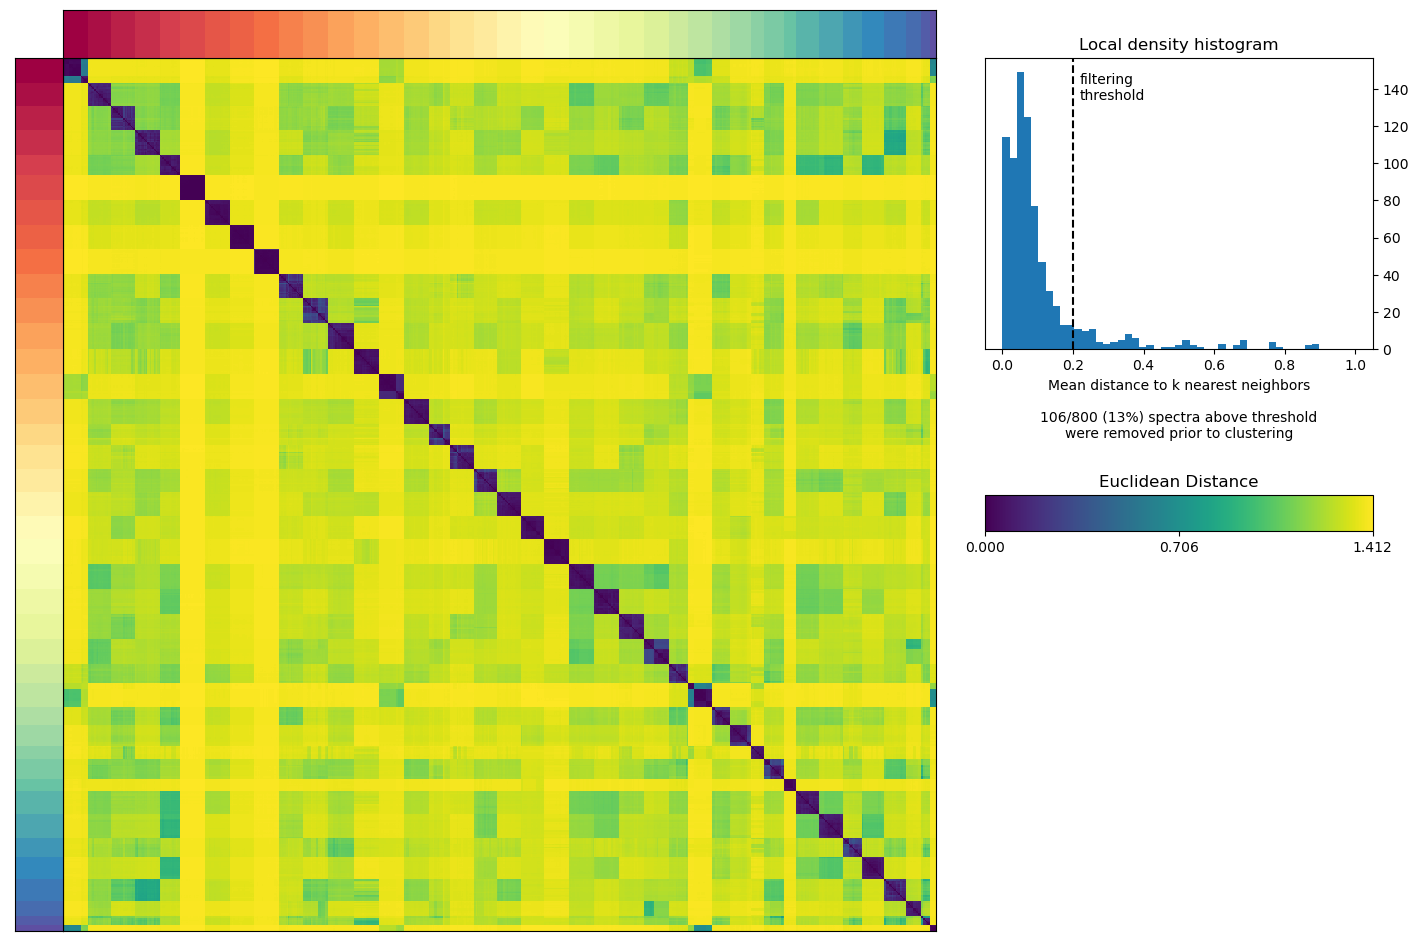

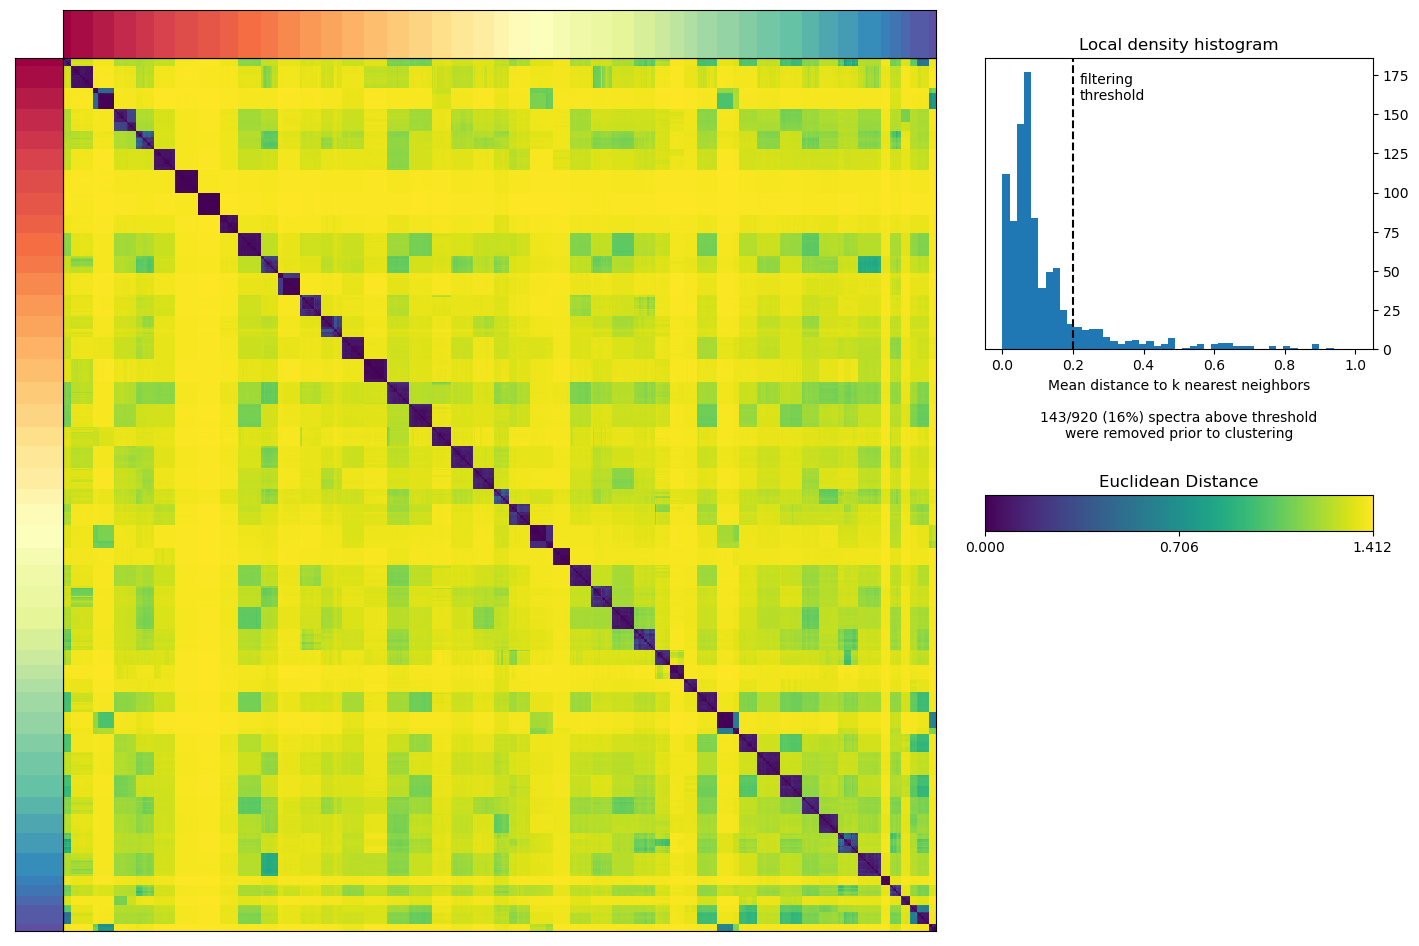

In [64]:
for k in [31, 32, 33, 34, 38, 39, 40, 46]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

## Compare with original TCATs

In [8]:
metagepinfo = read_dataset_log(tabname='Current Meta-program Paths').loc[0,:]
metagepinfo

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [18]:
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clustering.head()

AMP-RA  \
CellCycle-G2M_CellCycle_G2M                  AMP-RA:CellCycle-G2M   
ISG                                                    AMP-RA:ISG   
gdT                                                           NaN   
Metallothionein                            AMP-RA:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  AMP-RA:CellCycle-Sphase   

                                                          UK-Covid  \
CellCycle-G2M_CellCycle_G2M                 UK-Covid:CellCycle_G2M   
ISG                                                   UK-Covid:ISG   
gdT                                                   UK-Covid:gdT   
Metallothionein                           UK-Covid:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      UK-Covid:CellCycle_S   

                                                           Pan-Tissue  \
CellCycle-G2M_CellCycle_G2M                  Pan-Tissue:CellCycle-G2M   
ISG                                                    Pan-Tissue:ISG   
gdT                                                               NaN   
Metallothionein                            Pan-Tissue:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Tissue:CellCycle-Sphase   

                                                        HIV-Vaccine  \
CellCycle-G2M_CellCycle_G2M               HIV-Vaccine:CellCycle_G2M   
ISG                                                 HIV-Vaccine:ISG   
gdT                                                 HIV-Vaccine:gdT   
Metallothionein                                                 NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    HIV-Vaccine:CellCycle_S   

                                                          COMBAT  \
CellCycle-G2M_CellCycle_G2M                 COMBAT:CellCycle_G2M   
ISG                                                   COMBAT:ISG   
gdT                                                   COMBAT:gdT   
Metallothionein                           COMBAT:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      COMBAT:CellCycle_S   

                                                        TBRU  \
CellCycle-G2M_CellCycle_G2M               TBRU:CellCycle_G2M   
ISG                                                 TBRU:ISG   
gdT                                                 TBRU:gdT   
Metallothionein                                          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    TBRU:DTL/FAM111B   

                                                           Pan-Cancer  
CellCycle-G2M_CellCycle_G2M                  Pan-Cancer:CellCycle-G2M  
ISG                                                    Pan-Cancer:ISG  
gdT                                                               NaN  
Metallothionein                            Pan-Cancer:Metallothionein  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Cancer:CellCycle-Sphase

In [19]:
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T

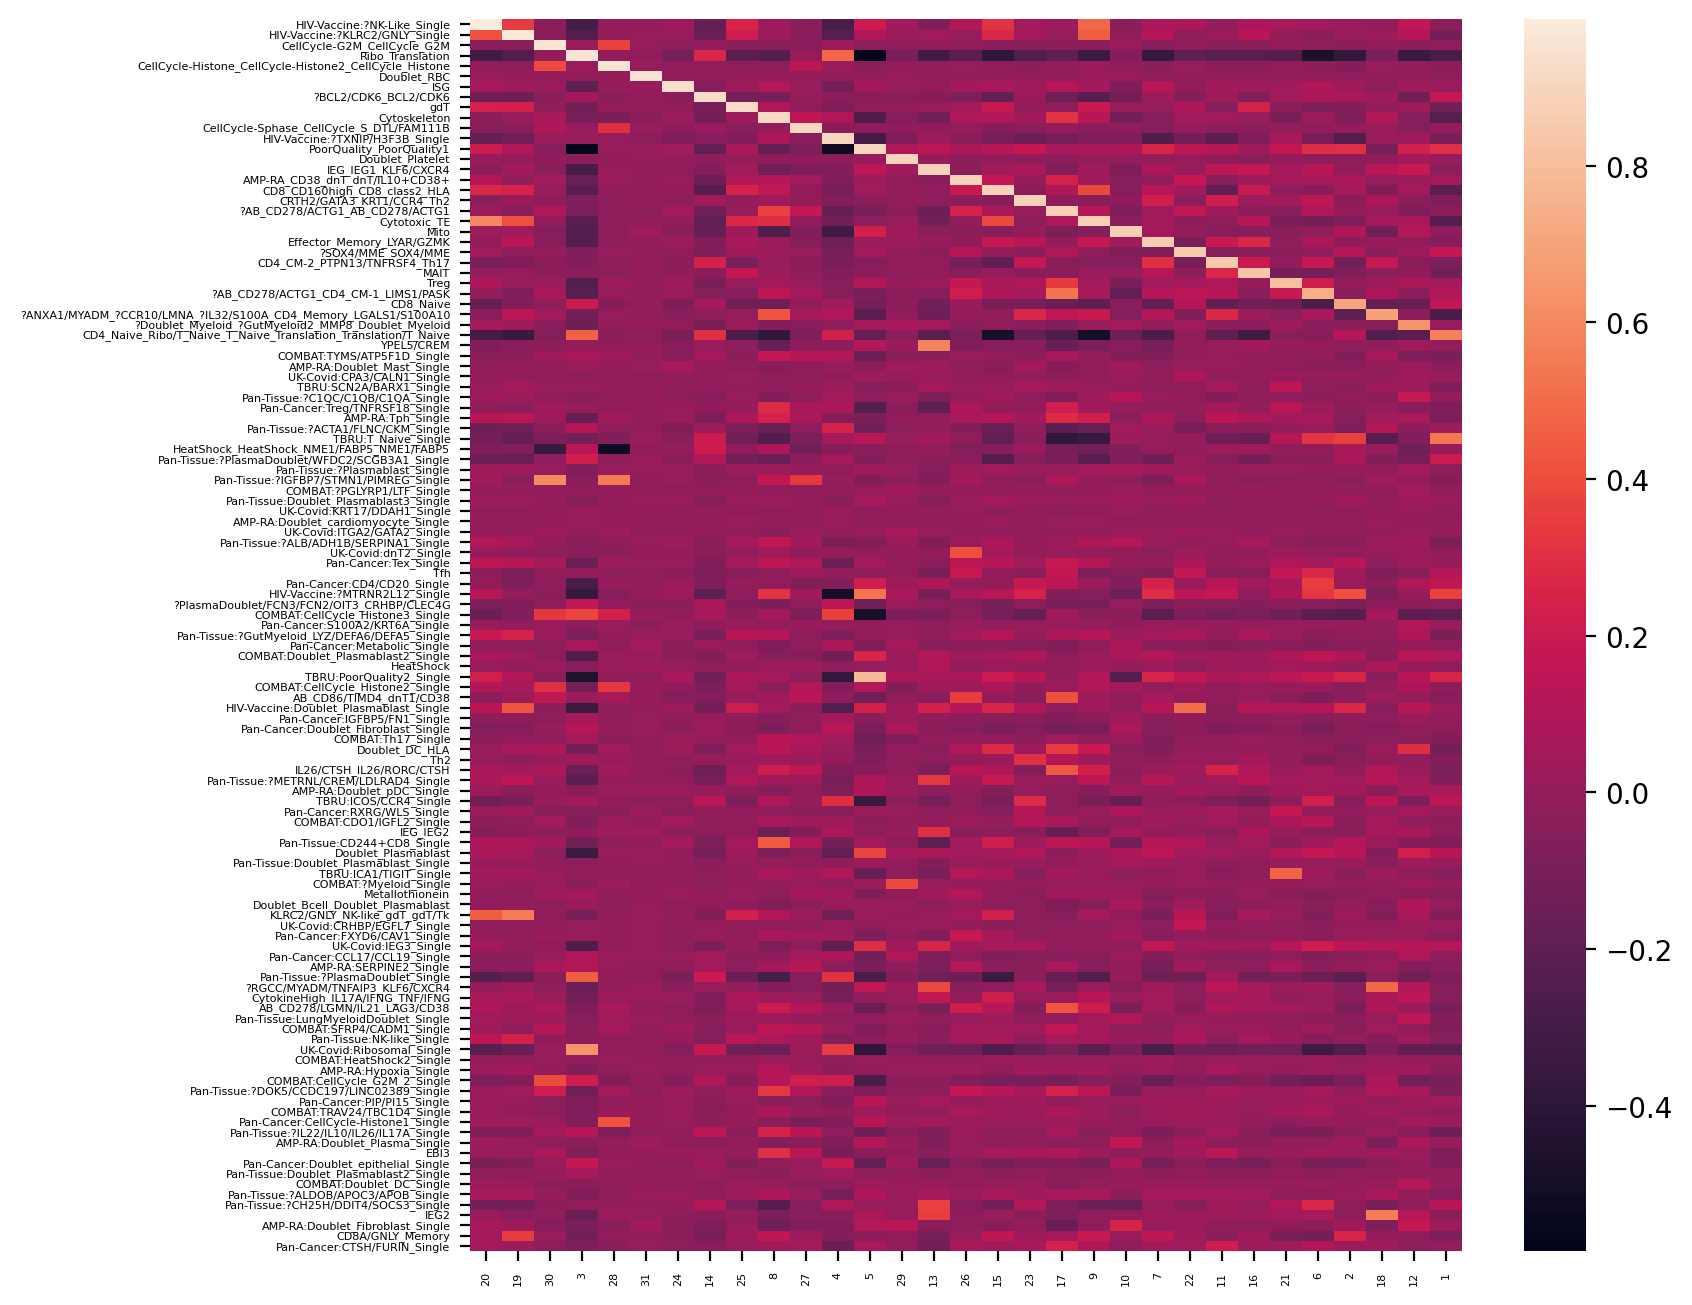

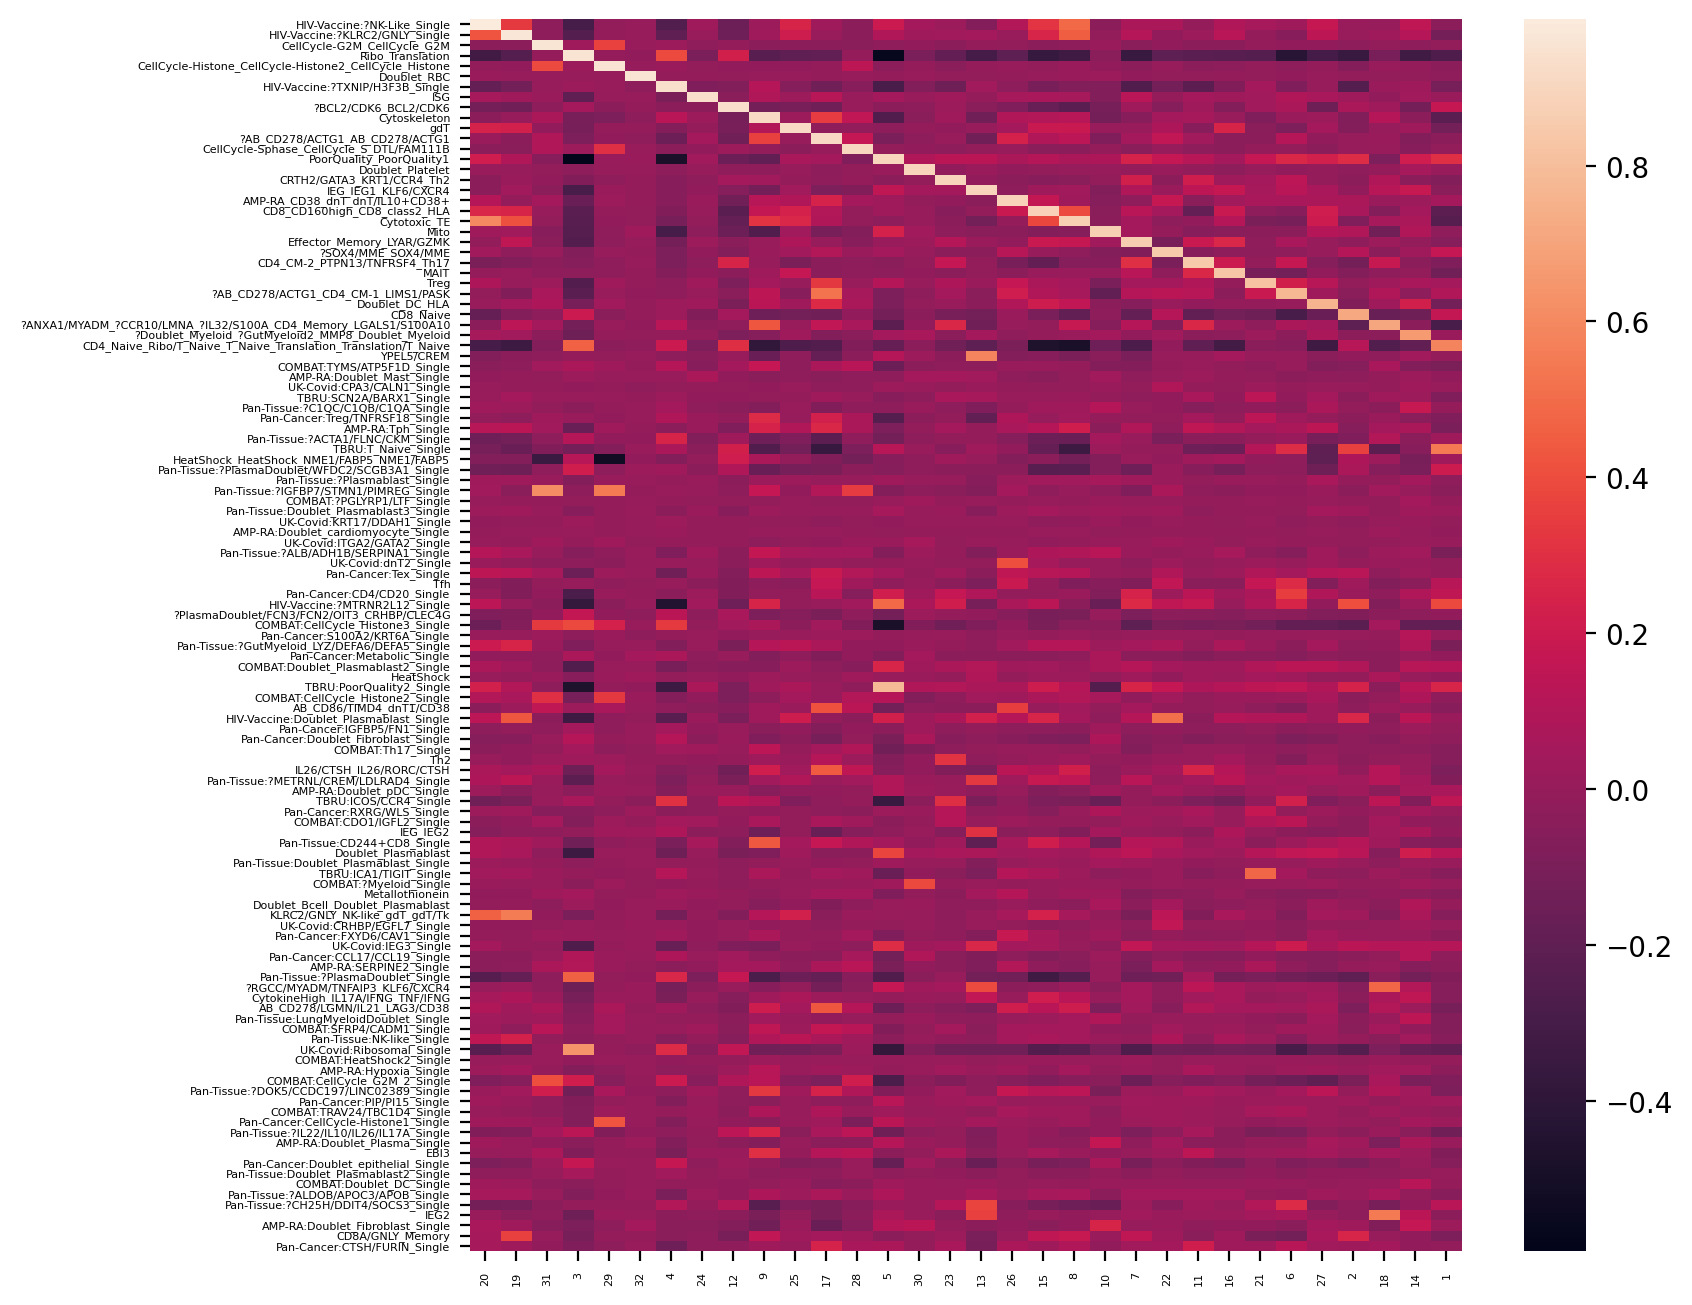

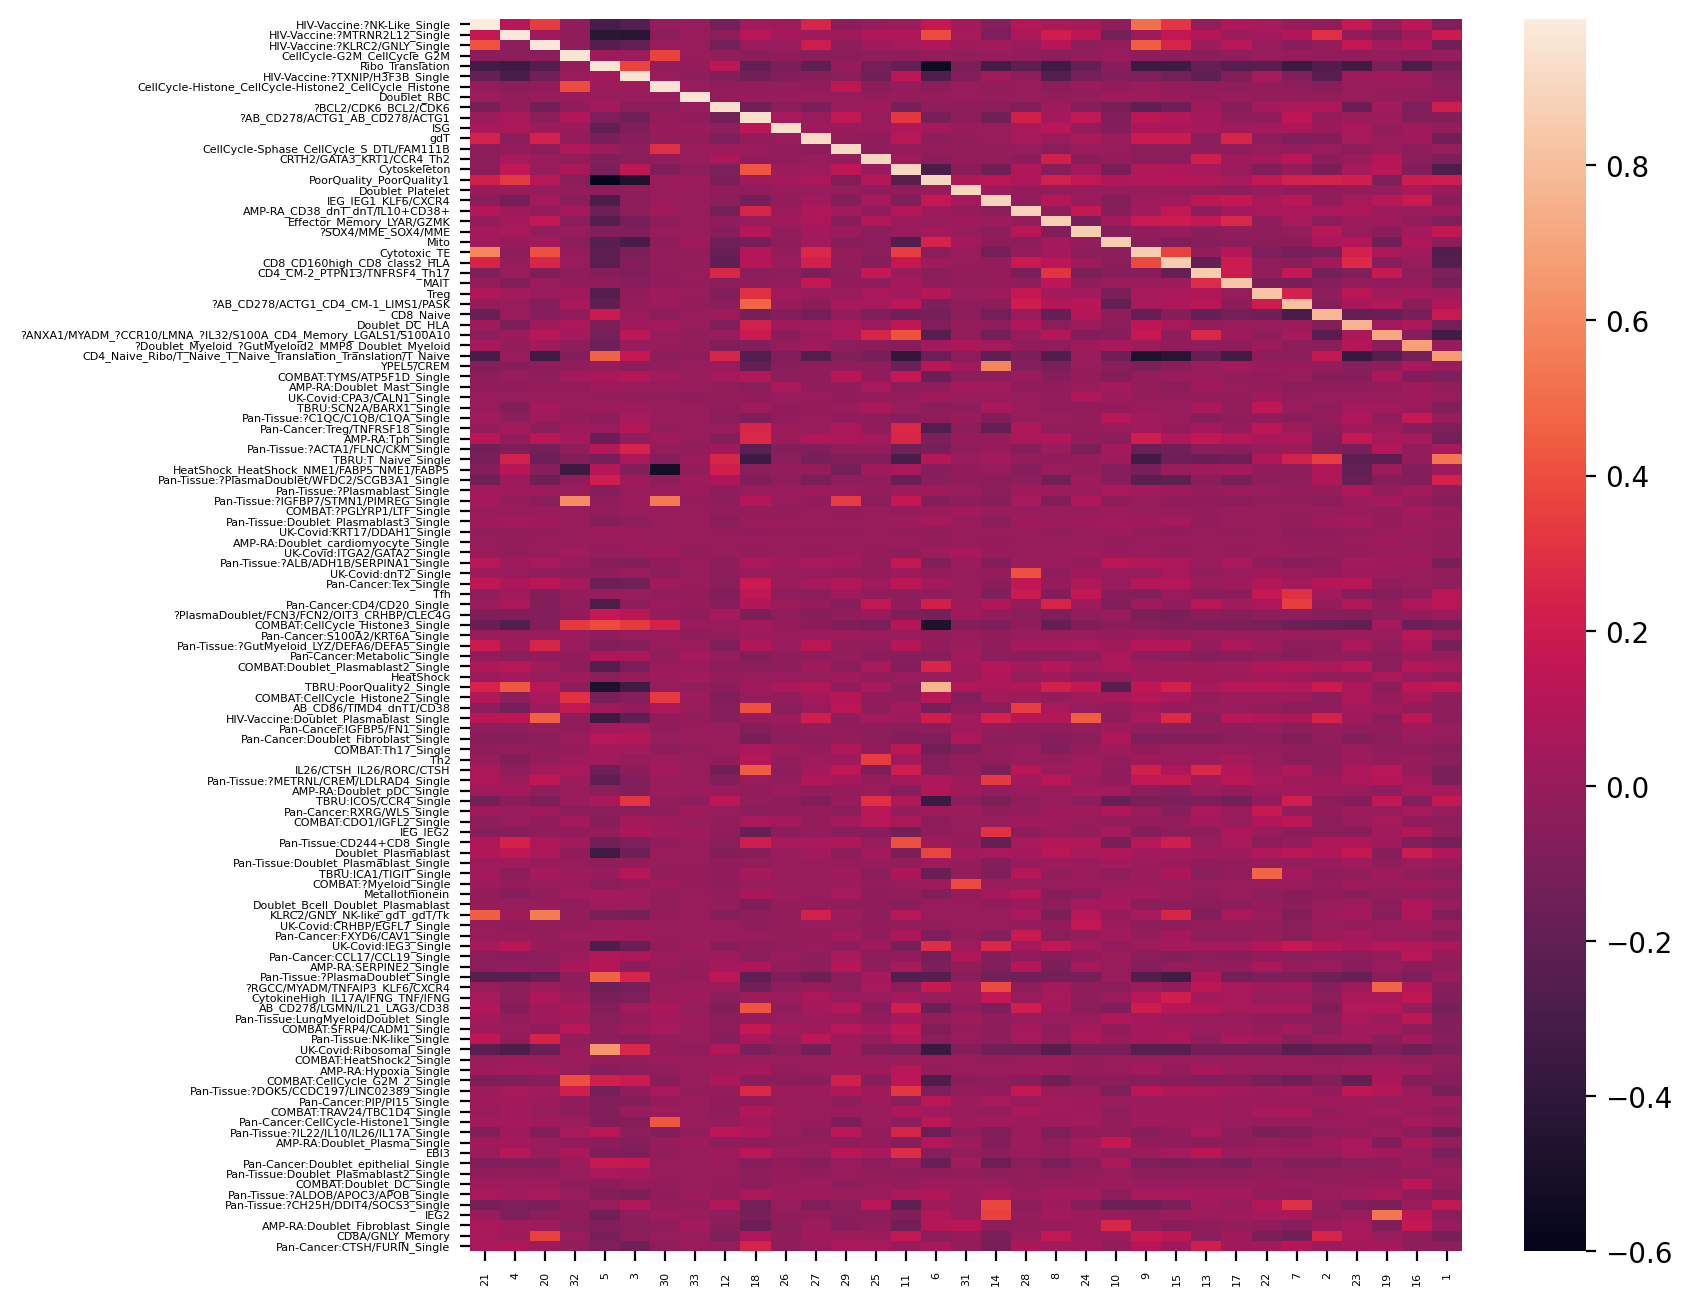

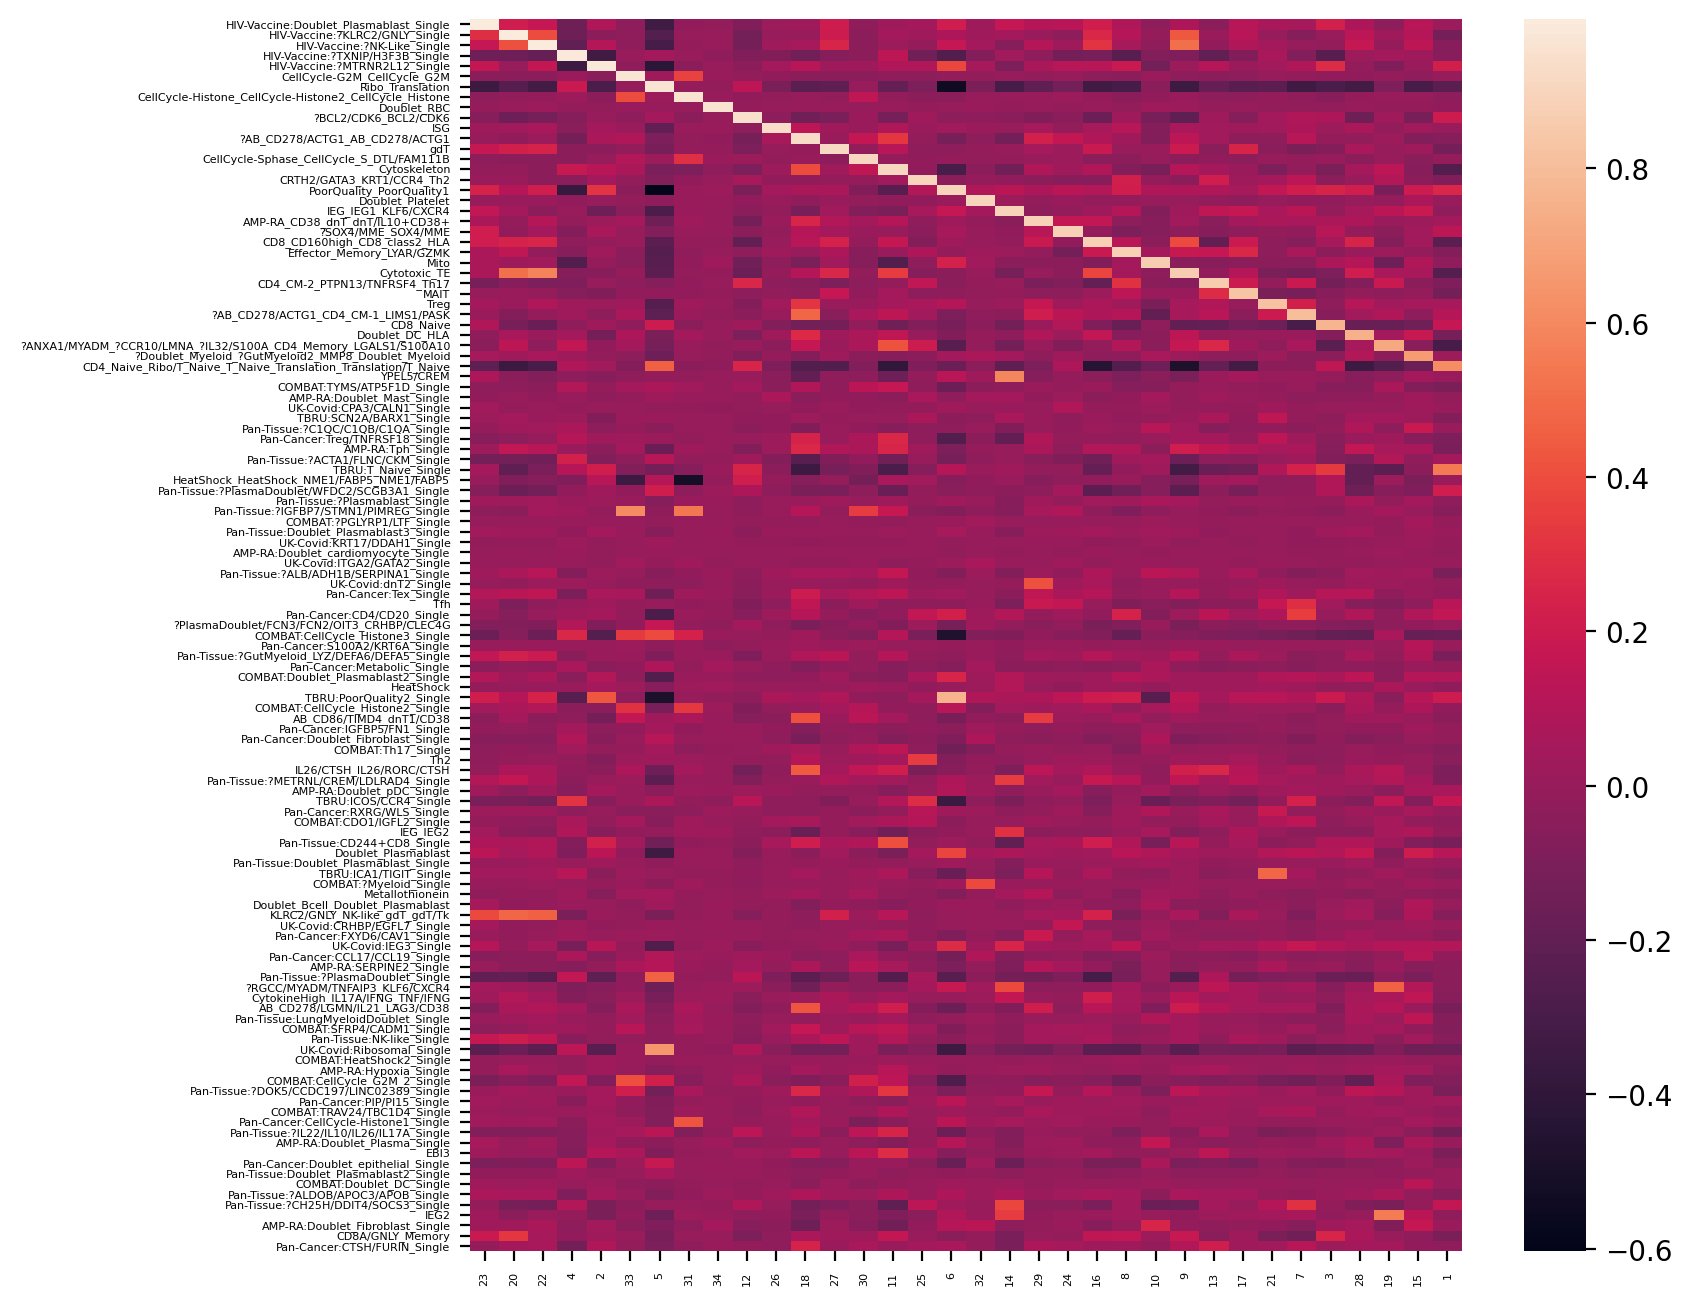

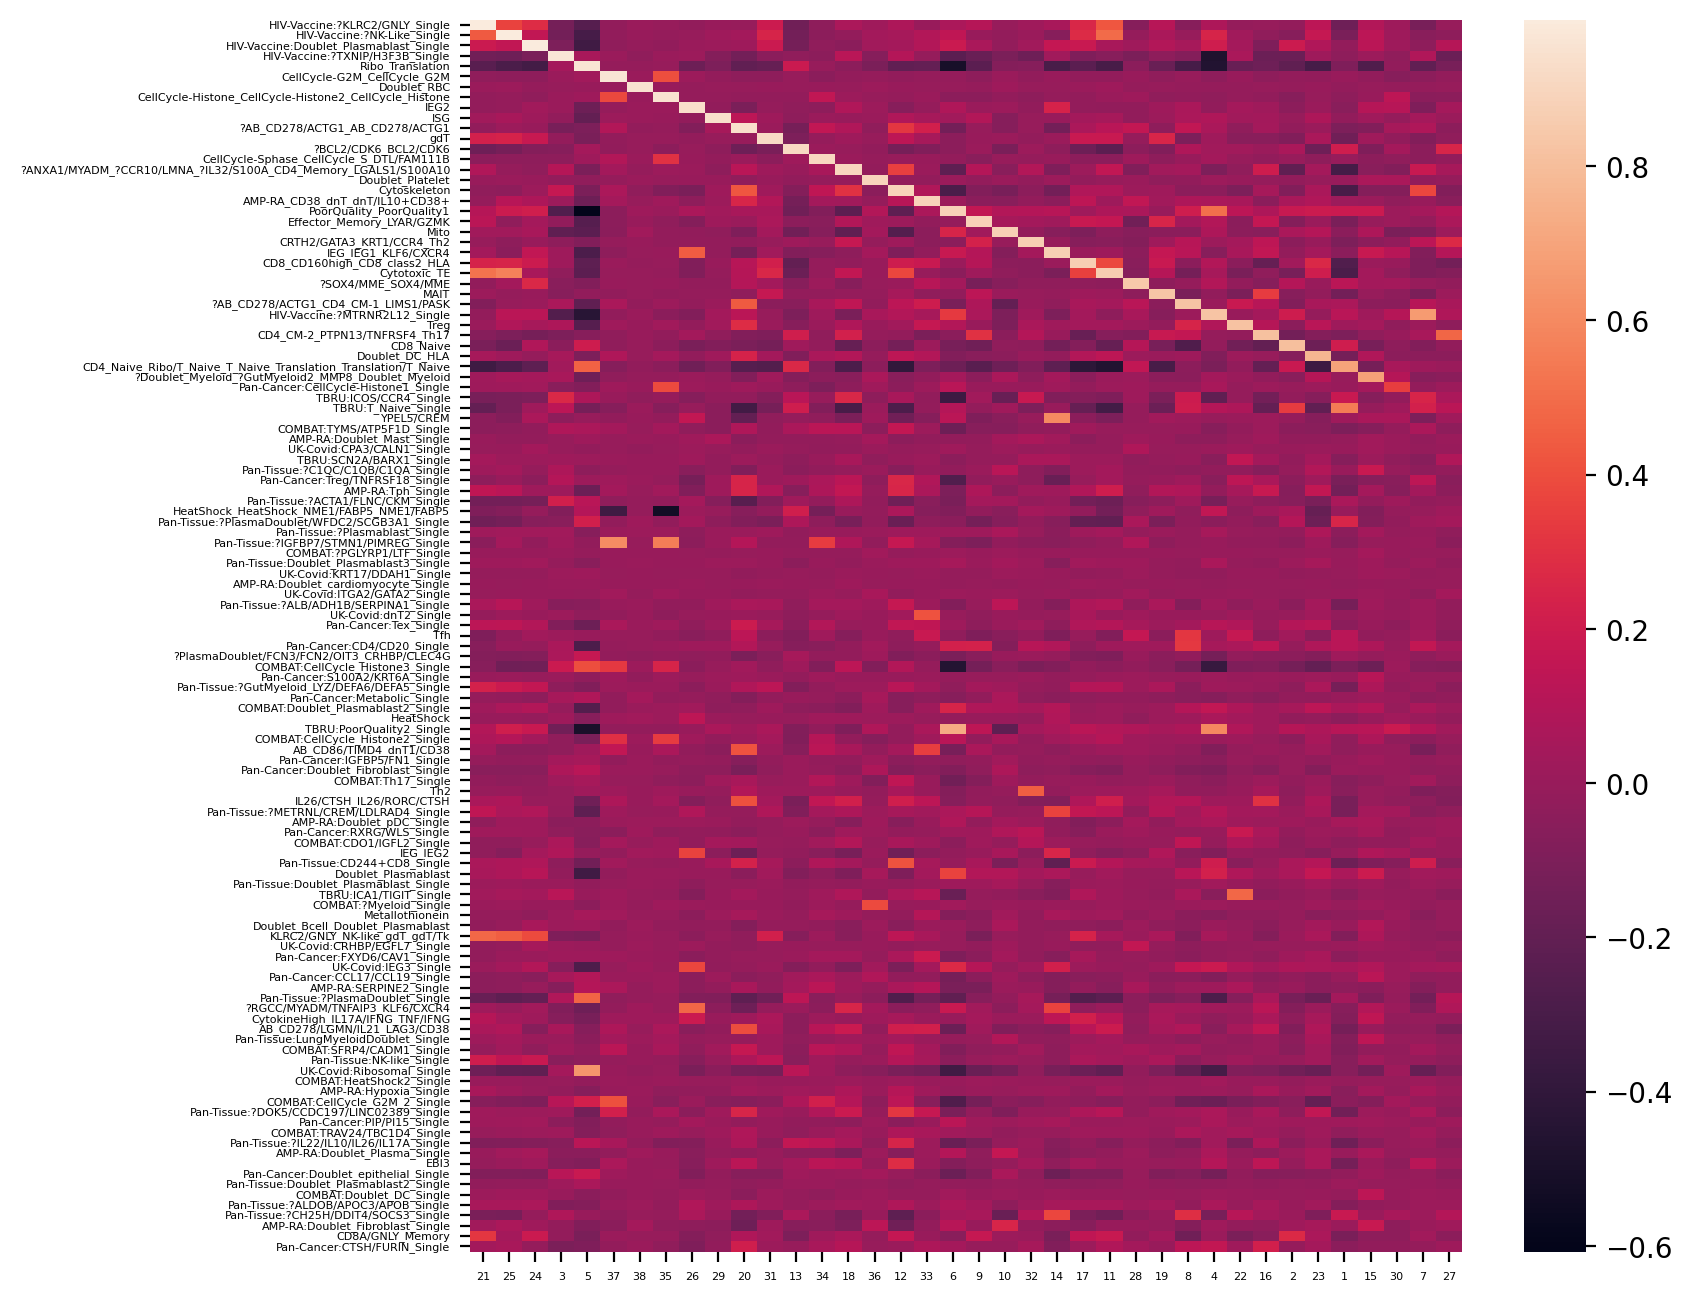

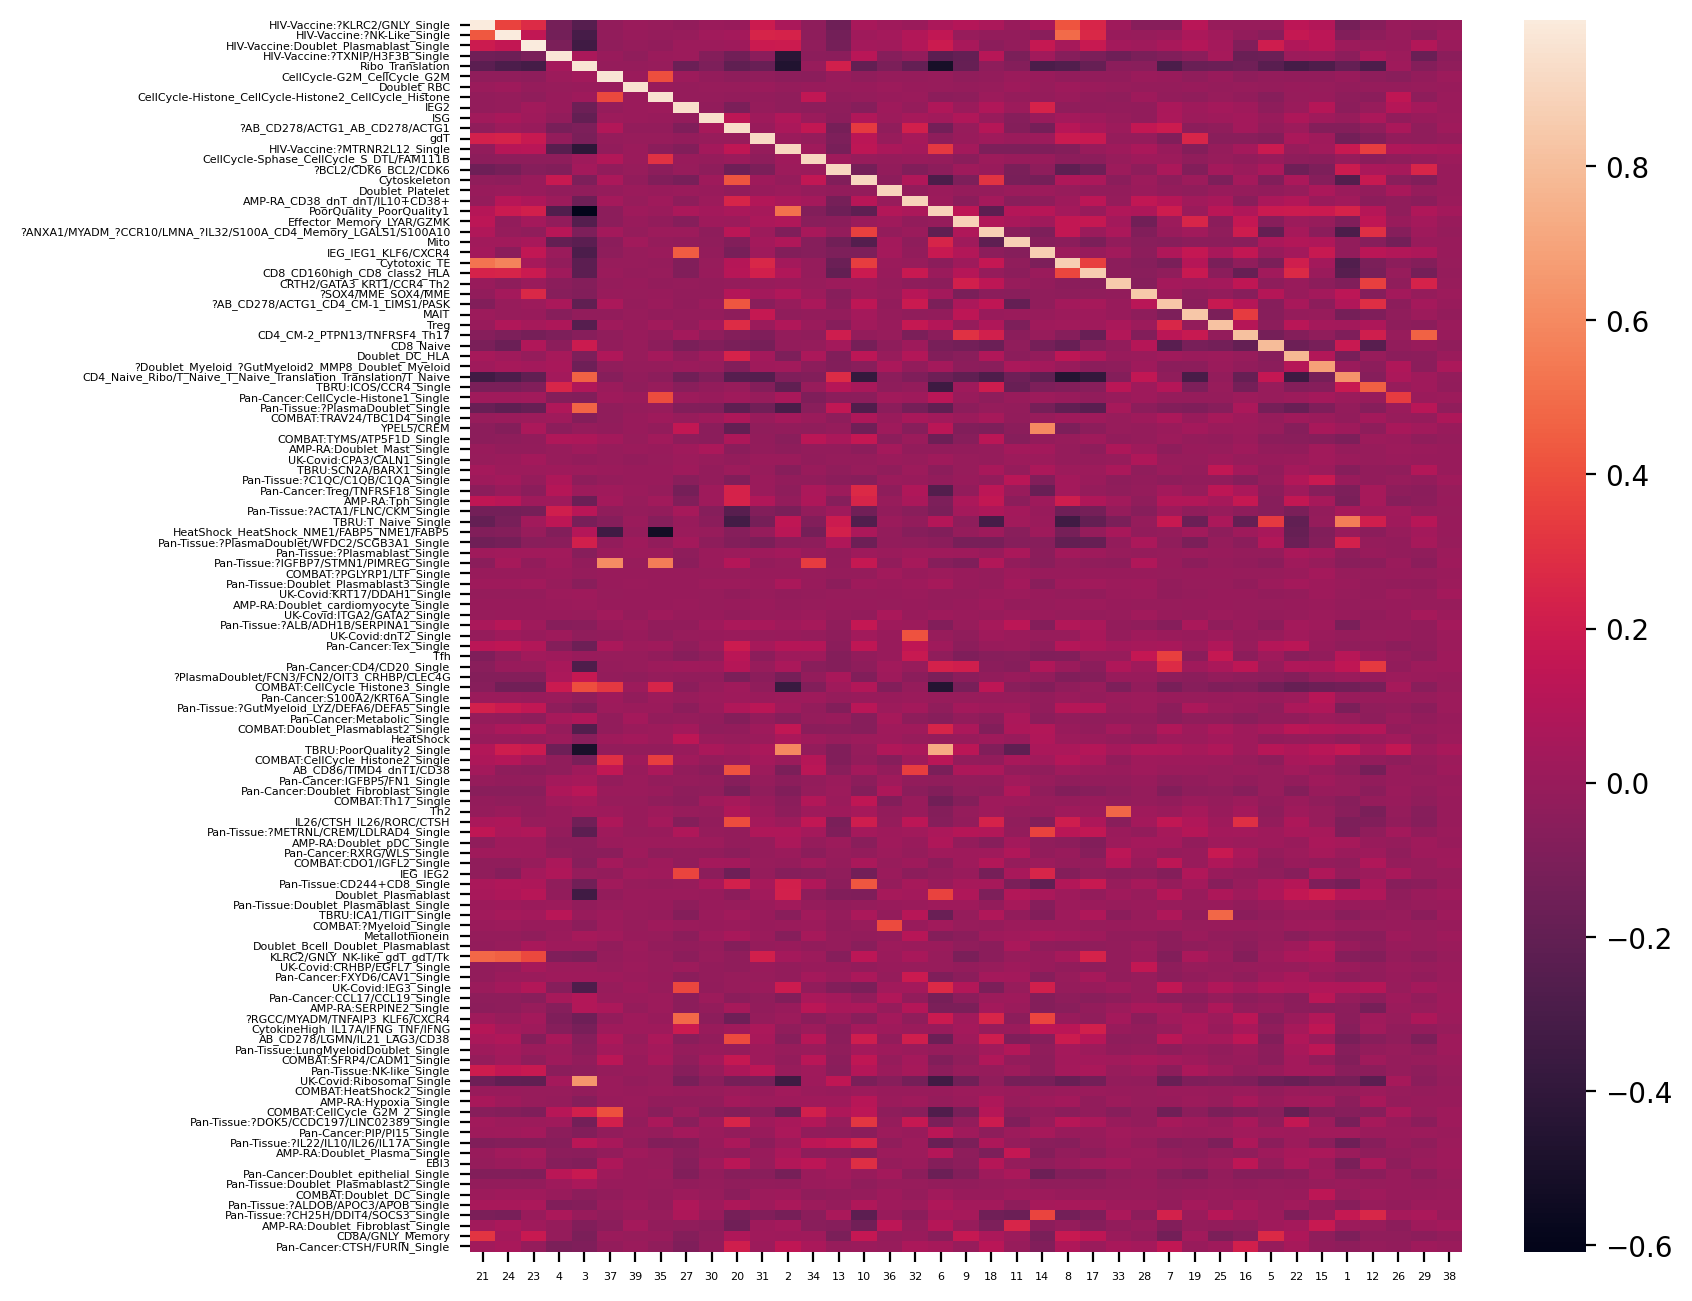

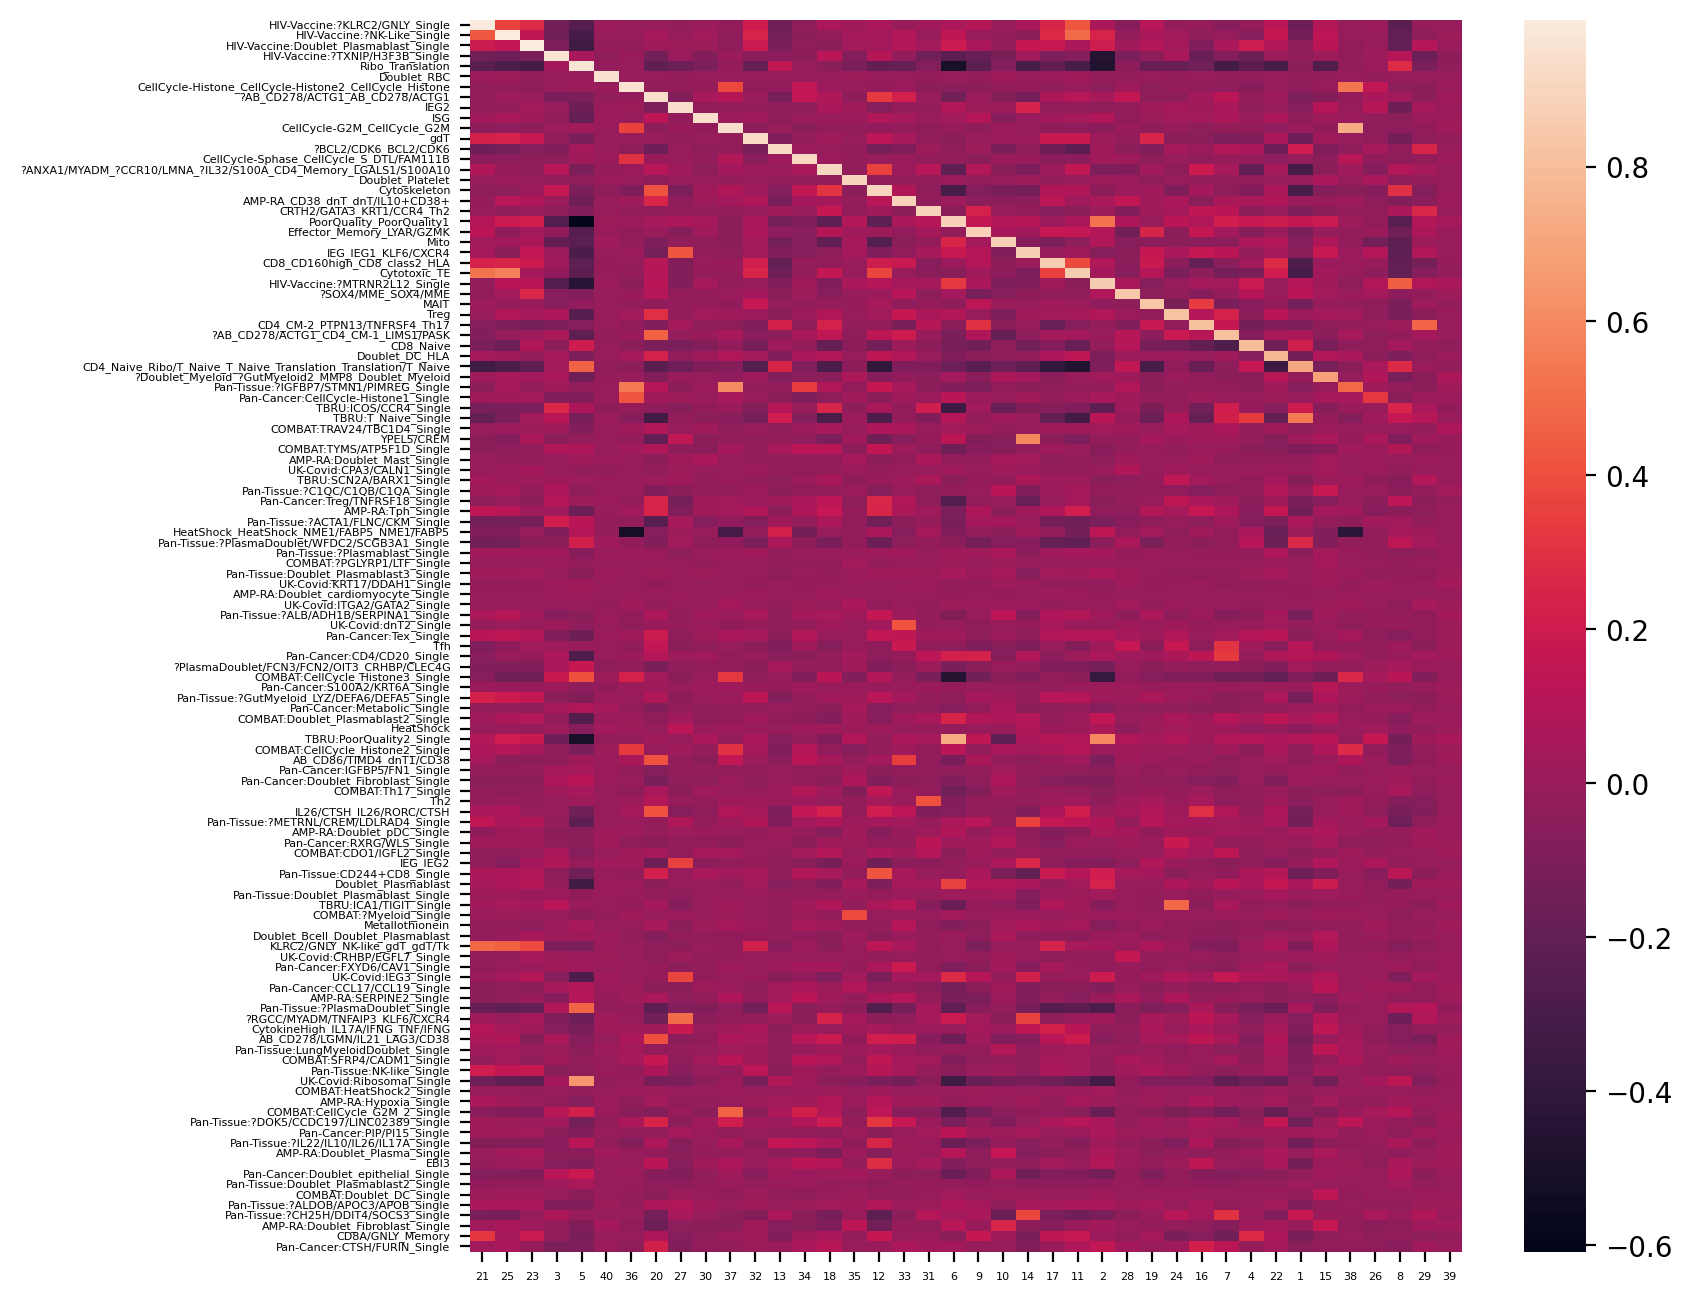

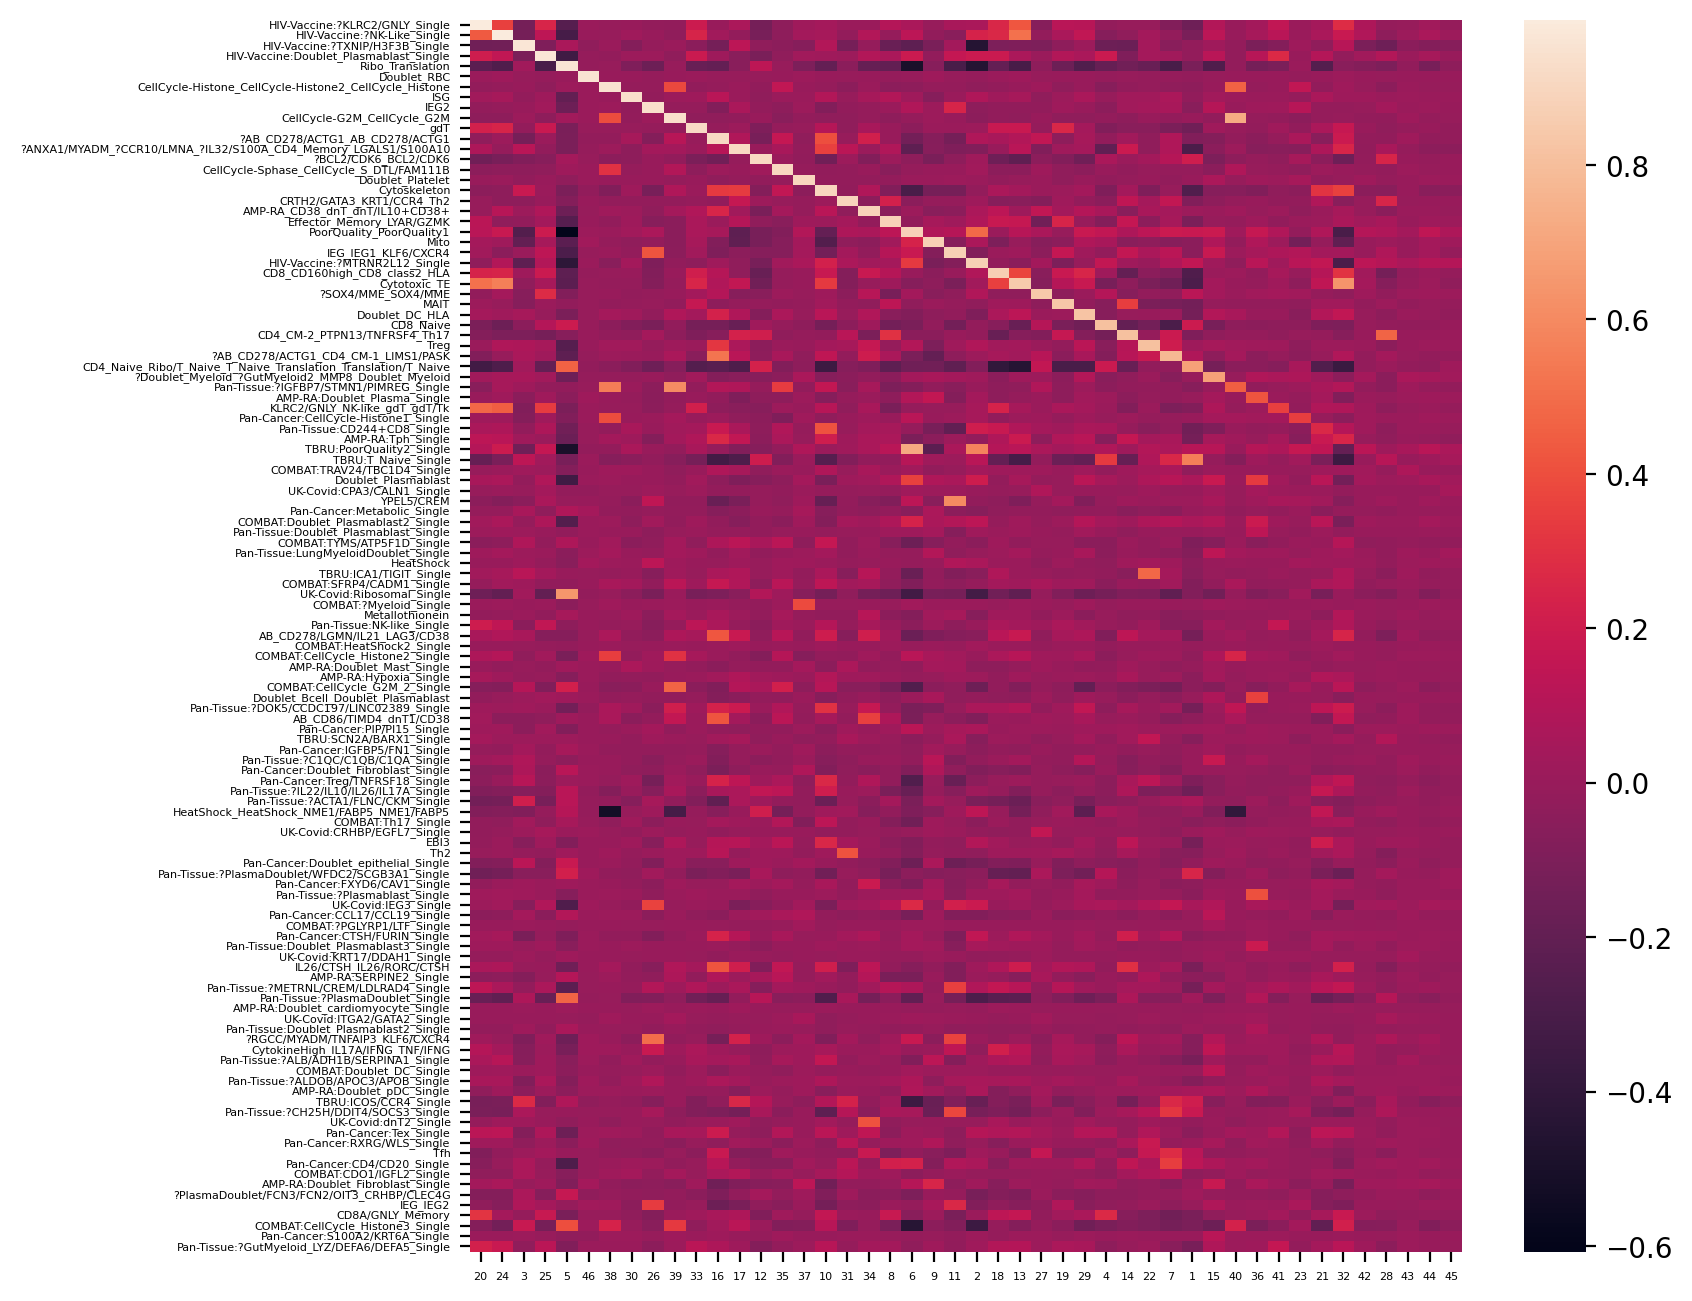

In [148]:
res = []
R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'Pan-Tissue', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'HIV-Vaccine'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

for k in [31, 32, 33, 34, 38, 39, 40, 46]:
    (usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
    overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
    mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
    R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
    rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
    top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
    top_genes_relabeled[k] = top_genes

    fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
    sns.heatmap(R_for_plot, ax=ax)
    ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
    ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
    ax.set_xticklabels(R_for_plot.columns, fontsize=4)
    ax.set_yticklabels(R_for_plot.index, fontsize=4)

    merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
    mapping_ref[k] = merge_annotation
    total_overlaps = (merge_annotation['R']>R_thresh).sum()
    ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
    nonsingleton_overlaps = ind.sum()
    this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
    recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
    new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
    res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])


In [149]:
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  31                31                             28   
1  32                32                             29   
2  33                33                             29   
3  34                34                             29   
4  38                35                             30   
5  39                35                             30   
6  40                35                             30   
7  46                35                             30   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             5                      3               0   
1                             5                      3               0   
2                             5                      4               0   
3                             5                      5               0   
4                             5                      5               3   
5                             5                      5               4   
6                             5                      5               5   
7                             5                      5              11   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
5                                       0  
6                                       0  
7                                       0

In [150]:
set(mapping_ref[38].loc[mapping_ref[38]['R']>R_thresh, 'X_columns']) - set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns'])

{'IEG2'}

In [151]:
mapping_ref[38].loc[mapping_ref[38]['X_columns']=='IEG2', :]

Y_columns X_columns         R AMP-RA UK-Covid Pan-Tissue  \
3002.0       26.0      IEG2  0.937363    NaN      NaN        NaN   

             HIV-Vaccine COMBAT       TBRU Pan-Cancer  
3002.0  HIV-Vaccine:IEG2    NaN  TBRU:IEG2        NaN

In [152]:
set(mapping_ref[32].loc[mapping_ref[32]['R']>R_thresh, 'X_columns']) - set(mapping_ref[31].loc[mapping_ref[31]['R']>R_thresh, 'X_columns'])

{'Doublet_DC_HLA'}

In [153]:
mapping_ref[32].loc[mapping_ref[32]['X_columns']=='Doublet_DC_HLA', :]

Y_columns       X_columns        R             AMP-RA      UK-Covid  \
3110.0       27.0  Doublet_DC_HLA  0.76154  AMP-RA:Doublet_DC  UK-Covid:HLA   

            Pan-Tissue      HIV-Vaccine      COMBAT      TBRU      Pan-Cancer  
3110.0  Pan-Tissue:HLA  HIV-Vaccine:HLA  COMBAT:HLA  TBRU:HLA  Pan-Cancer:HLA

In [157]:
top_genes_relabeled[32]['Doublet_DC_HLA'].head(30)

0     HLA-DRB1
1     HLA-DRB5
2      HLA-DRA
3         CD74
4     HLA-DQB1
5     HLA-DQA1
6     HLA-DPA1
7     HLA-DPB1
8      HLA-DMA
9          B2M
10       HLA-A
11     HLA-DMB
12        GZMA
13       HLA-B
14       HLA-C
15       PDIA3
16    HLA-DQA2
17       PTPRC
18        CALR
19       HSPA5
20        SLF1
21        CYBA
22     HERPUD1
23     HSP90B1
24      GOLIM4
25        EMP3
26      ATP1B3
27         CD2
28        CD81
29      RNF213
Name: Doublet_DC_HLA, dtype: object

In [162]:
set(mapping_ref[33].loc[mapping_ref[33]['R']>R_thresh, 'X_columns']) - set(mapping_ref[32].loc[mapping_ref[32]['R']>R_thresh, 'X_columns'])

{'HIV-Vaccine:?MTRNR2L12_Single'}

In [161]:
set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns']) - set(mapping_ref[32].loc[mapping_ref[32]['R']>R_thresh, 'X_columns'])

{'HIV-Vaccine:?MTRNR2L12_Single', 'HIV-Vaccine:Doublet_Plasmablast_Single'}

In [163]:
set(mapping_ref[38].loc[mapping_ref[38]['R']>R_thresh, 'X_columns']) - set(mapping_ref[32].loc[mapping_ref[32]['R']>R_thresh, 'X_columns'])

{'HIV-Vaccine:?MTRNR2L12_Single',
 'HIV-Vaccine:Doublet_Plasmablast_Single',
 'IEG2'}

# K=31

In [171]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.20230907.Iter200'

In [172]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(31, 32)
n_iter = 200
num_per_node = 4

In [173]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [174]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [175]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [176]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.20230907.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200/log/HIVVaccine.20230907.Iter200.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200/log/HIVVaccine.20230907.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.20230907.Iter200 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 50 --worker-index 0"
Job <839757> is submitted to queue <short>.
bsub -q short -J HIVVaccine.20230907.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200/log/HIVVaccine.20230907.Iter200.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200/log/HIVVaccine.20230907.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "

In [193]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
839781  dk718   RUN   short      cn071       cn077       *7.Iter200 Sep  9 15:52
839805  dk718   RUN   short      cn071       cmu147      *7.Iter200 Sep  9 15:53
839806  dk718   RUN   short      cn071       cmu149      *7.Iter200 Sep  9 15:53


In [197]:
! bjobs | wc -l

No unfinished job found
0


In [198]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [207]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [208]:
missing

[]

In [209]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

## Look at the results for K=31 with 200 iterations

In [211]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=31.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


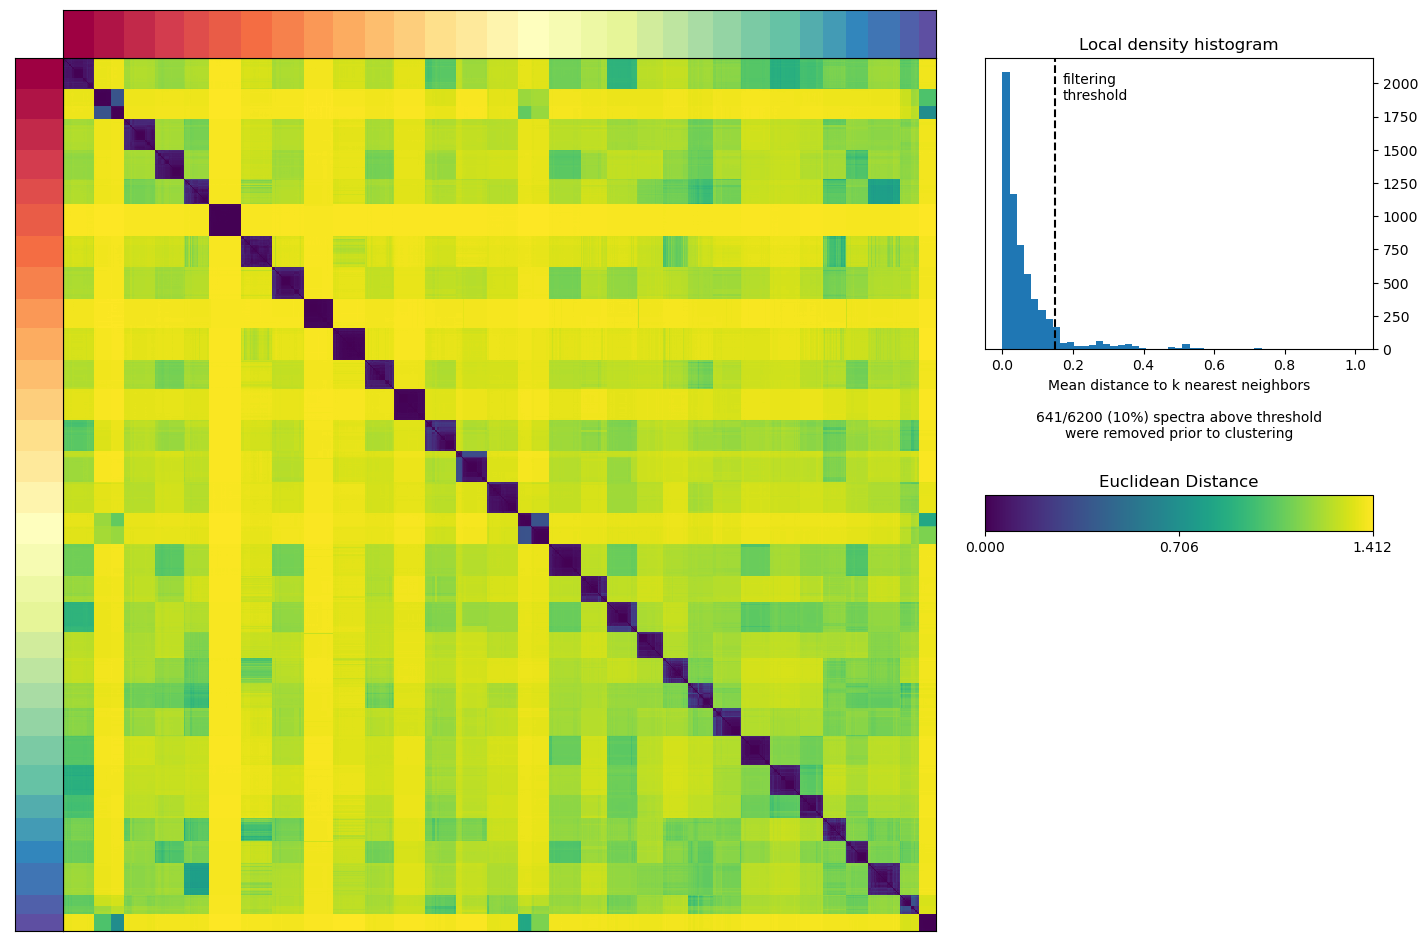

In [212]:
cnmf_obj.consensus(k=31, density_threshold=0.15)

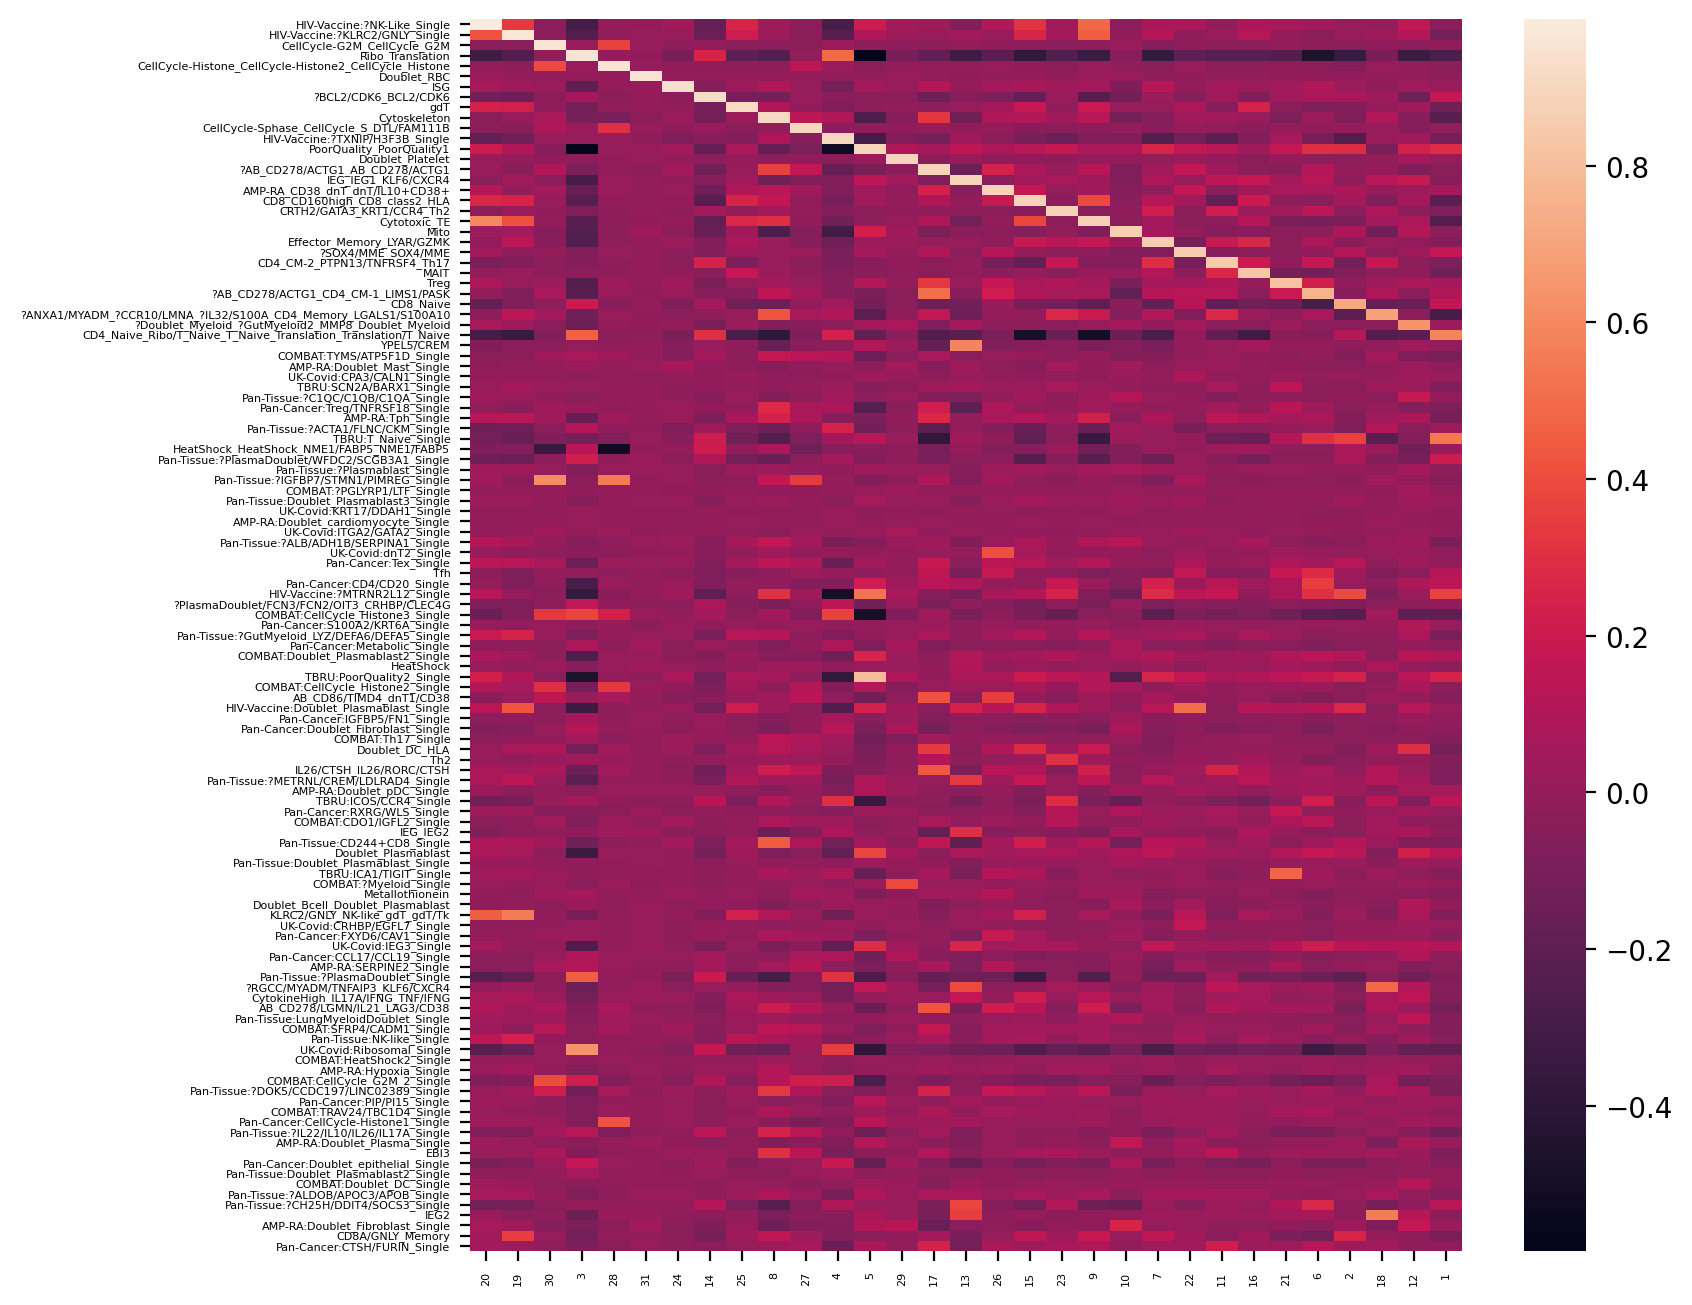

In [235]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=31, density_threshold=0.15)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [236]:
res = []
k=31
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  31                31                             28   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             5                      3               0   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0

In [237]:
os.path.abspath(cnmfdir)

'/data/srlab1/TCAT/Data/PerDataset/HaoEtAl'

In [238]:
name

'HIVVaccine.20230907.Iter200'

In [239]:
os.path.abspath('.')

'/data/srlab1/TCAT/Analysis/PerDataset/HaoEtAl'

In [240]:
gep_info = read_dataset_log('GEP_Name')
gep_info.index = gep_info['MetaGep_Name']
gep_info.head()

MetaGep_Name  \
MetaGep_Name                                                                         
CellCycle-G2M_CellCycle_G2M                            CellCycle-G2M_CellCycle_G2M   
ISG                                                                            ISG   
gdT                                                                            gdT   
Metallothionein                                                    Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  CellCycle-Sphase_CellCycle_S_DTL/FAM111B   

                                                            Long_Name  \
MetaGep_Name                                                            
CellCycle-G2M_CellCycle_G2M                      Cell Cycle G2M Phase   
ISG                                       Interferon Stimulated Genes   
gdT                                               Gamma Delta T Blood   
Metallothionein                                       Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B           Cell Cycle S Phase   

                                               Short_Name Needs Review  \
MetaGep_Name                                                             
CellCycle-G2M_CellCycle_G2M                 CellCycle-G2M          NaN   
ISG                                                   ISG          NaN   
gdT                                             gdT-Blood          NaN   
Metallothionein                           Metallothionein          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      CellCycle-S          NaN   

                                                   Class  Num_Datasets Flag  
MetaGep_Name                                                                 
CellCycle-G2M_CellCycle_G2M               Known Activity           7.0  NaN  
ISG                                       Known Activity           7.0  NaN  
gdT                                        Known Lineage           4.0  NaN  
Metallothionein                           Known Activity           5.0  NaN  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Known Activity           7.0  NaN

In [252]:
gep2meta = dict(zip(mapping['Y_columns'], mapping['X_columns']))
meta2rename = dict(zip(gep_info['MetaGep_Name'], gep_info['Short_Name']))
meta2rename['HIV-Vaccine:?TXNIP/H3F3B_Single'] = 'HIV-Vaccine:?TXNIP/H3F3B_Single'
gep2rename = {g:meta2rename[gep2meta[g]] for g in gep2meta.keys()}

In [253]:
usage_rename = usage.rename(columns=gep2rename)
spectra_scores_rename = spectra_scores.rename(columns=gep2rename)
spectra_tpm_rename = spectra_tpm.rename(columns=gep2rename)

In [259]:
for dat, lab in [(usage_rename, 'Usage'), (spectra_scores_rename, 'Spectra_Scores'), (spectra_tpm_rename, 'Spectra_TPM')]:
    fn = os.path.join(cnmfdir, name +'.'+lab+'.Relabeled.tsv')
    print(os.path.abspath(fn))
    dat.to_csv(fn, sep='\t')

/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200.Usage.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200.Spectra_Scores.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVVaccine.20230907.Iter200.Spectra_TPM.Relabeled.tsv


In [269]:
top_genes_relabed = {}
for g in spectra_scores_rename.columns:
    top_genes_relabed[g] = spectra_scores_rename[g].sort_values(ascending=False).iloc[:50].index
    
top_genes_relabed = pd.DataFrame.from_dict(top_genes_relabed).T

In [271]:
top_genes_relabed

0            1          2   \
CD4-Naive                            IL6ST         CCR7       FHIT   
CD8-Naive                        LINC02446       AB_CD8    AB_CD8a   
Translation                          RPS18         RPS8       RPL3   
HIV-Vaccine:?TXNIP/H3F3B_Single      TXNIP        H3F3B       H1FX   
MALAT1                              MALAT1        MACF1       UTRN   
CD4 TCM                              LIMS1         PASK     GPR183   
CD4 TEM                               IL7R         LYAR     PTGER2   
Cytoskeleton                          ACTB        ACTG1       PFN1   
Cytotoxic                           FGFBP2         GZMH       NKG7   
Mito                               MT-ATP6       MT-CYB     MT-CO2   
Th17                                PTPN13      TNFRSF4      PDE4D   
Doublet-Myeloid                        LYZ       S100A9     S100A8   
IEG                                   JUNB       ZNF331      NR4A2   
BCL2/CDK6                             BCL2         CDK6       PIM1   
CD8_EM                                CMC1        CD160       XCL2   
MAIT                              AB_CD161      SLC4A10      KLRB1   
ICOS/ACTG1                        AB_CD278  MIR4435-2HG      NEAT1   
S100A10/LMNA                         ANXA1         LMNA     TAGLN2   
KLRC2/GNLY                           KLRC2         GNLY      NCAM1   
NK-Like-2                           FCGR3A        KLRF1       PRF1   
Treg                                 FOXP3      AB_CD25      RTKN2   
SOX4/MME                              SOX4          MME     CASC15   
Th2                                   KRT1       PTGDR2      GATA3   
ISG                                  ISG15          MX1       IFI6   
gdT-Blood                             TRDC        TRDV2      TRGC1   
IL10/CD38                             CAV1          MYB  MIR4422HG   
CellCycle-S                            DTL        GINS2    FAM111B   
CellCycle-Histone                 HIST1H3G     HIST1H3B   HIST1H1B   
Doublet-Platelet                      PPBP         NRGN      SPARC   
CellCycle-G2M                       DLGAP5        CDC20      CCNB2   
Doublet-RBC                            HBB         HBA2       HBA1   

                                           3           4         5   \
CD4-Naive                                SELL       SATB1      TCF7   
CD8-Naive                                CD8B     AB_CD73     NELL2   
Translation                              RPS6       RPS4X      RPS3   
HIV-Vaccine:?TXNIP/H3F3B_Single        RPS4Y1       RPL30      BTG1   
MALAT1                                 GOLGA4      GOLGB1     SYNE2   
CD4 TCM                                 AP3M2        FYB1     TSHZ2   
CD4 TEM                                 ITGA1       CXCR3  IFNG-AS1   
Cytoskeleton                             CFL1       CLIC1      LCP1   
Cytotoxic                               PROK2        GZMB     EFHD2   
Mito                                   MT-ND4      MT-CO3    MT-ND3   
Th17                                     CCR6        CTSH  TNFRSF18   
Doublet-Myeloid                       HLA-DRA        VCAN      FCN1   
IEG                                   TNFAIP3     ZFP36L2     CXCR4   
BCL2/CDK6                              FAM13A        CISH       MAL   
CD8_EM                                  EOMES    AB_TIGIT      CCL5   
MAIT                             AB_TCR-V-7.2    AB_CD195      NCR3   
ICOS/ACTG1                              ACTG1     AB_CD71     CTLA4   
S100A10/LMNA                            MYADM       CRIP1   S100A10   
KLRC2/GNLY                          AB_CD158b      ZNF683      HOPX   
NK-Like-2                             AB_CD16       CTBP2      GZMB   
Treg                                    IL2RA       FANK1     TIGIT   
SOX4/MME                                 TOX2       CHST2    IGFBP2   
Th2                                 GATA3-AS1        NEFL    SEMA5A   
ISG                                    IFI44L       IFIT3     IFIT1   
gdT-Blood               